In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from plot_utils import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']

strategies = [
    ('equal', EPIDEMIC['ws_vacc'], 'Pop only'),
    ('no_vacc', EPIDEMIC['ws_vacc'], 'No vaccination'),
    ('thl', EPIDEMIC['ws_vacc'], 'Pop, Inf and Hosp'),
    ('thl', [1/2, 1/2, 0], 'Pop and Hosp'),
    ('thl', [1/2, 0, 1/2], 'Pop and Inf'),
    ('thl', [0, 1/2, 1/2], 'Hosp and Inf'),
    ('thl', [0, 1, 0], 'Hosp only'),
    ('thl', [0, 0, 1], 'Inf only'),
]

In [3]:
all_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=True,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0)

Finished R: 1.0. 1/4. Policy: Pop only. 1/8
Finished R: 1.0. 1/4. Policy: No vaccination. 2/8
Finished R: 1.0. 1/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.0. 1/4. Policy: Pop and Hosp. 4/8
Finished R: 1.0. 1/4. Policy: Pop and Inf. 5/8
Finished R: 1.0. 1/4. Policy: Hosp and Inf. 6/8
Finished R: 1.0. 1/4. Policy: Hosp only. 7/8
Finished R: 1.0. 1/4. Policy: Inf only. 8/8
Finished R: 1.25. 2/4. Policy: Pop only. 1/8
Finished R: 1.25. 2/4. Policy: No vaccination. 2/8
Finished R: 1.25. 2/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.25. 2/4. Policy: Pop and Hosp. 4/8
Finished R: 1.25. 2/4. Policy: Pop and Inf. 5/8
Finished R: 1.25. 2/4. Policy: Hosp and Inf. 6/8
Finished R: 1.25. 2/4. Policy: Hosp only. 7/8
Finished R: 1.25. 2/4. Policy: Inf only. 8/8
Finished R: 1.5. 3/4. Policy: Pop only. 1/8
Finished R: 1.5. 3/4. Policy: No vaccination. 2/8
Finished R: 1.5. 3/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.5. 3/4. Policy: Pop and Hosp. 4/8
Finished R: 1.5. 3/4. Policy: Pop and I

In [61]:
# 57 is 2021-06-15
# T-30 is 2021-07-13
# T is 2021-08-11
def plot_ervas(ax, r, metric, all_results, ervas_labels, t2=T, t1=T-30):
    len_bar = 5
    sep_bet_ervas = 3*len_bar
    color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    
    results_for_r = all_results[r]
    
    total_strategies = len(results_for_r)
    space_erva = len_bar*(total_strategies-1) + sep_bet_ervas
    
    no_vacc_results = None
    for label, results_all_metrics in results_for_r:
        if label == 'No vaccination':
            no_vacc_results = results_all_metrics[metric]
            no_vacc_results = no_vacc_results.sum(axis=0)
            no_vacc_results = no_vacc_results[:, t1:t2]
    
    assert no_vacc_results is not None
    assert no_vacc_results.shape[0] == len(ervas_labels)
    
    total_plot_space = space_erva*len(ervas_labels) + sep_bet_ervas
    ax.set_xlim(0, total_plot_space)
    ax.set_ylim(0, 100)
    
    num_strategy = 0
    legend_elements = []
    for label, results_all_metrics in results_for_r:
        if label != 'No vaccination':
            policy_results = results_all_metrics[metric]
            policy_results = policy_results.sum(axis=0)
            policy_results = policy_results[:, t1:t2]

            assert policy_results.shape == no_vacc_results.shape
            relative_to_no_vacc = (no_vacc_results - policy_results)/no_vacc_results
            
            min_red_all_ervas = relative_to_no_vacc.min(axis=1)*100
            max_red_all_ervas = relative_to_no_vacc.max(axis=1)*100
            
            
            for erva_i in range(len(ervas_labels)):
                x1_square = erva_i*space_erva + sep_bet_ervas + num_strategy*len_bar
                y1_square = min_red_all_ervas[erva_i]
                y2_square = max_red_all_ervas[erva_i] - min_red_all_ervas[erva_i]

                ax.broken_barh([(x1_square, len_bar), ], (y1_square, y2_square),
                               color=color_palette[num_strategy])
                
            legend_elements.append(Line2D([0], [0], color=color_palette[num_strategy], lw=2, label=label))
            
            num_strategy += 1
    
    space_bars = space_erva - sep_bet_ervas
    middle_of_space = space_bars/2
    pos_tick =  sep_bet_ervas + middle_of_space
    ticks = []
    for erva_i in range(len(ervas_labels)):
        abs_pos_tick = erva_i*space_erva + pos_tick
        ticks.append(abs_pos_tick)
        
    assert len(ticks) == len(ervas_labels)
    assert len(legend_elements) == total_strategies-1
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(ervas_labels)
    ax.set_yticks(np.arange(0, 105, 5))
    ax.legend(handles=legend_elements, loc='lower left')
    ax.set_xlabel('ERVAs')
    ax.set_ylabel('Reduction in percentage')
    ax.set_title('Reduction in %s at ERVA per policy . R=%s' % (metric, r))
    

    return ax

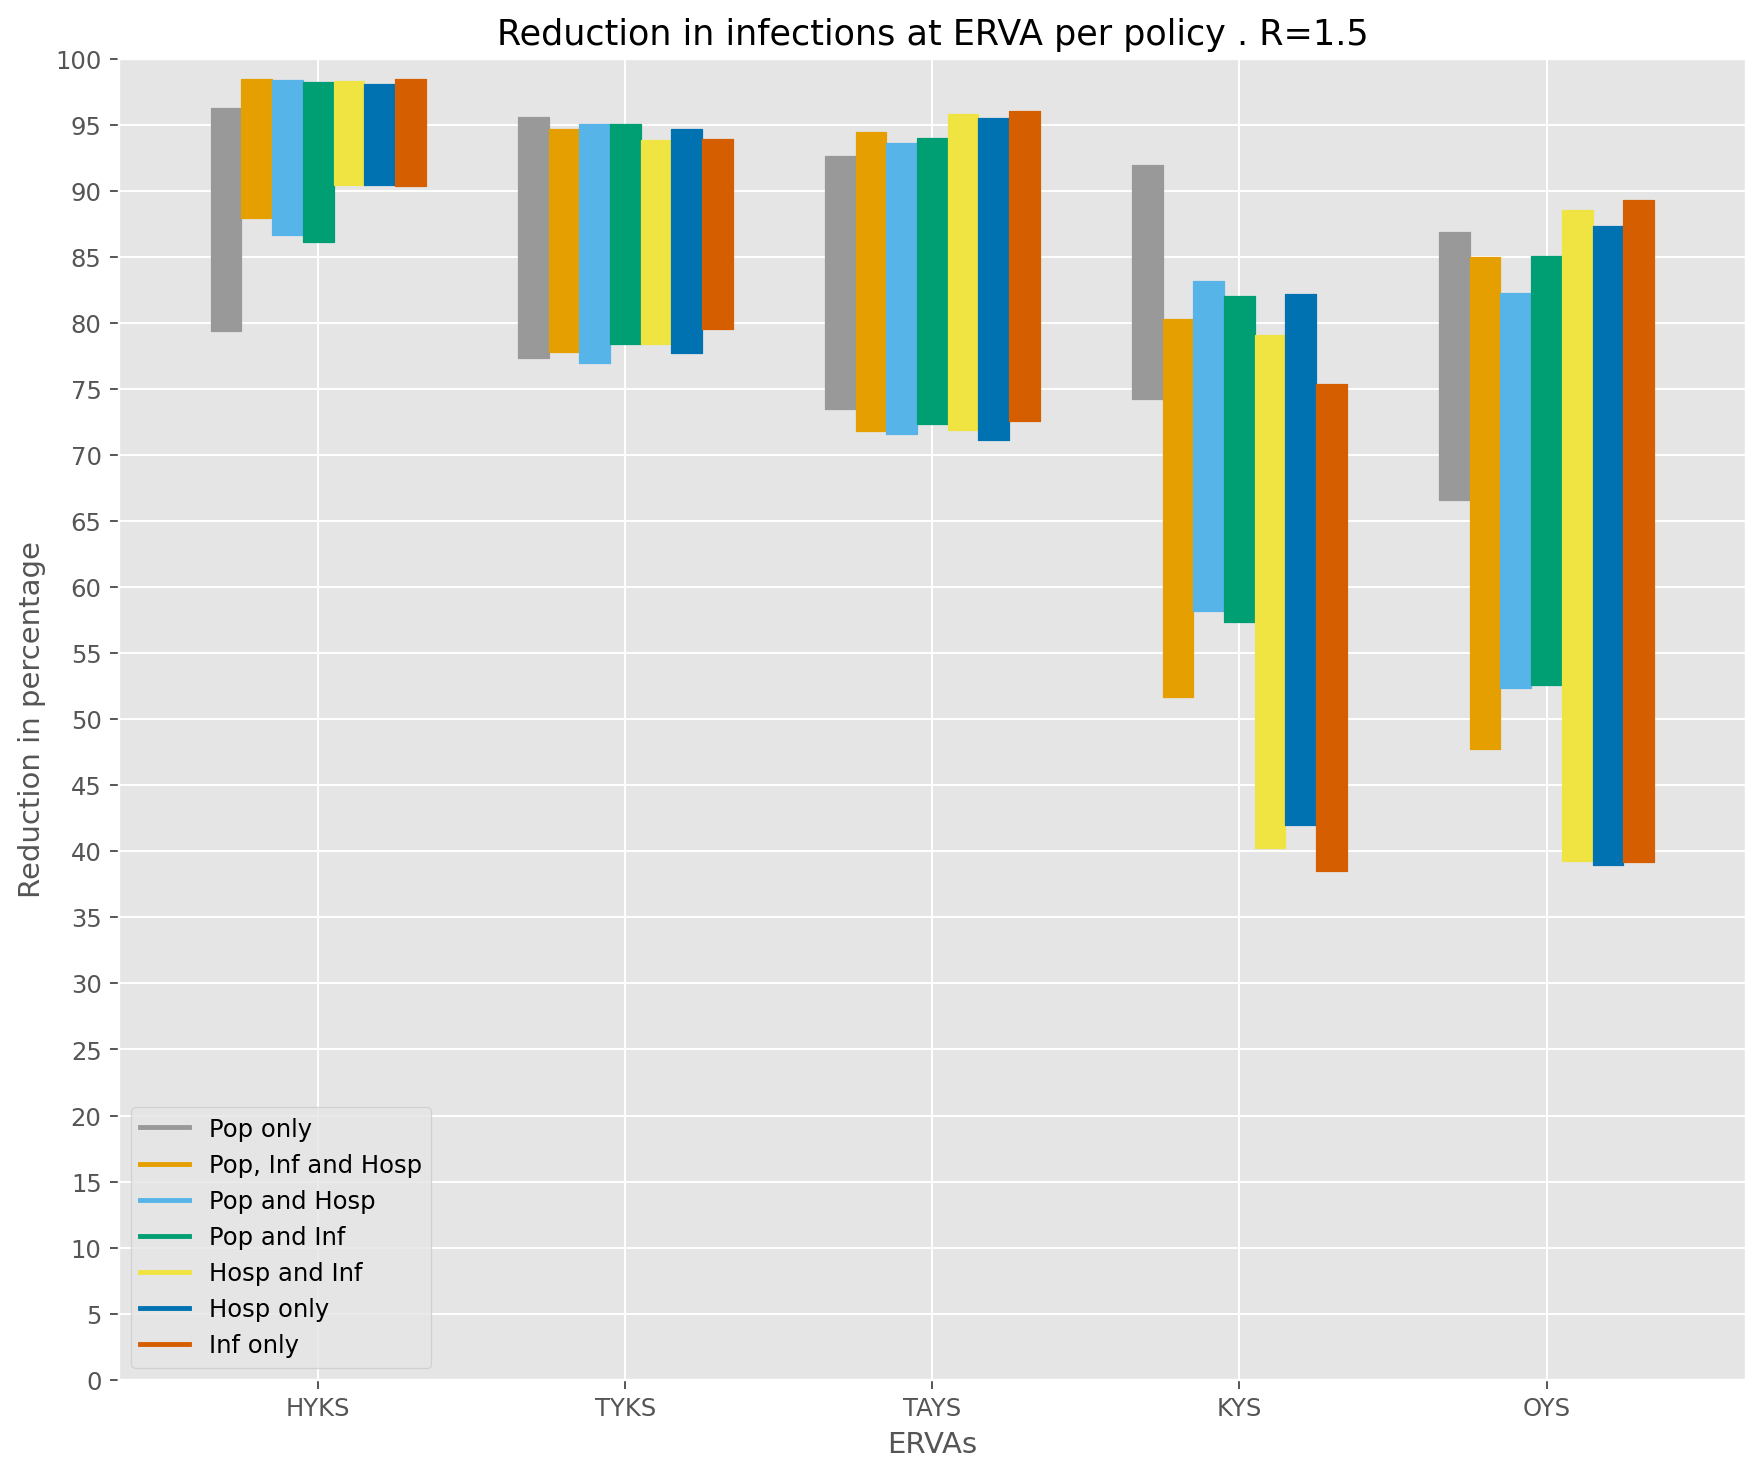

In [62]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[2], 'infections', all_results, ervas_labels)

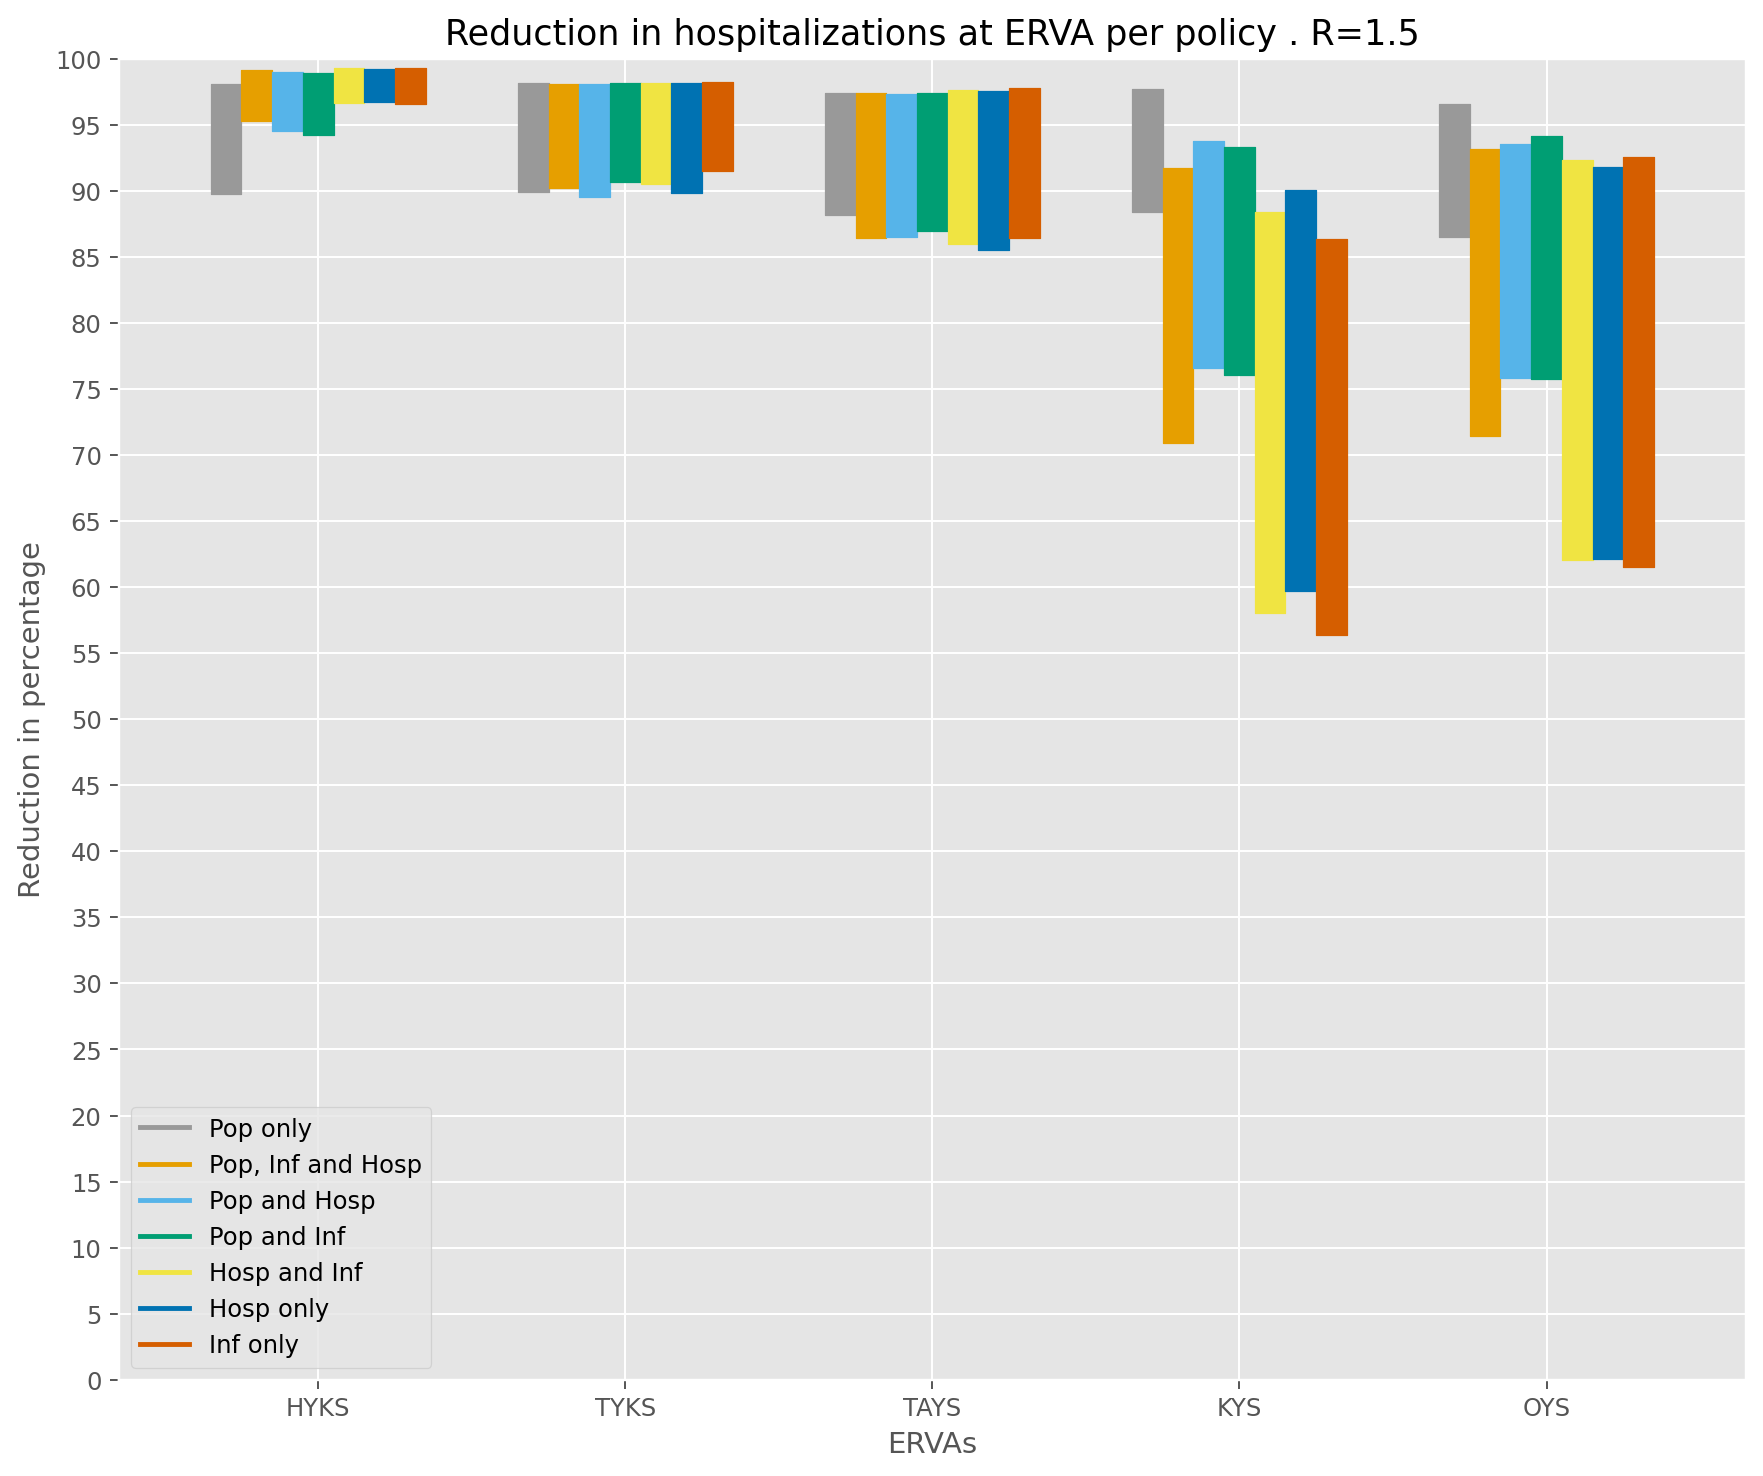

In [63]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[2], 'hospitalizations', all_results, ervas_labels)

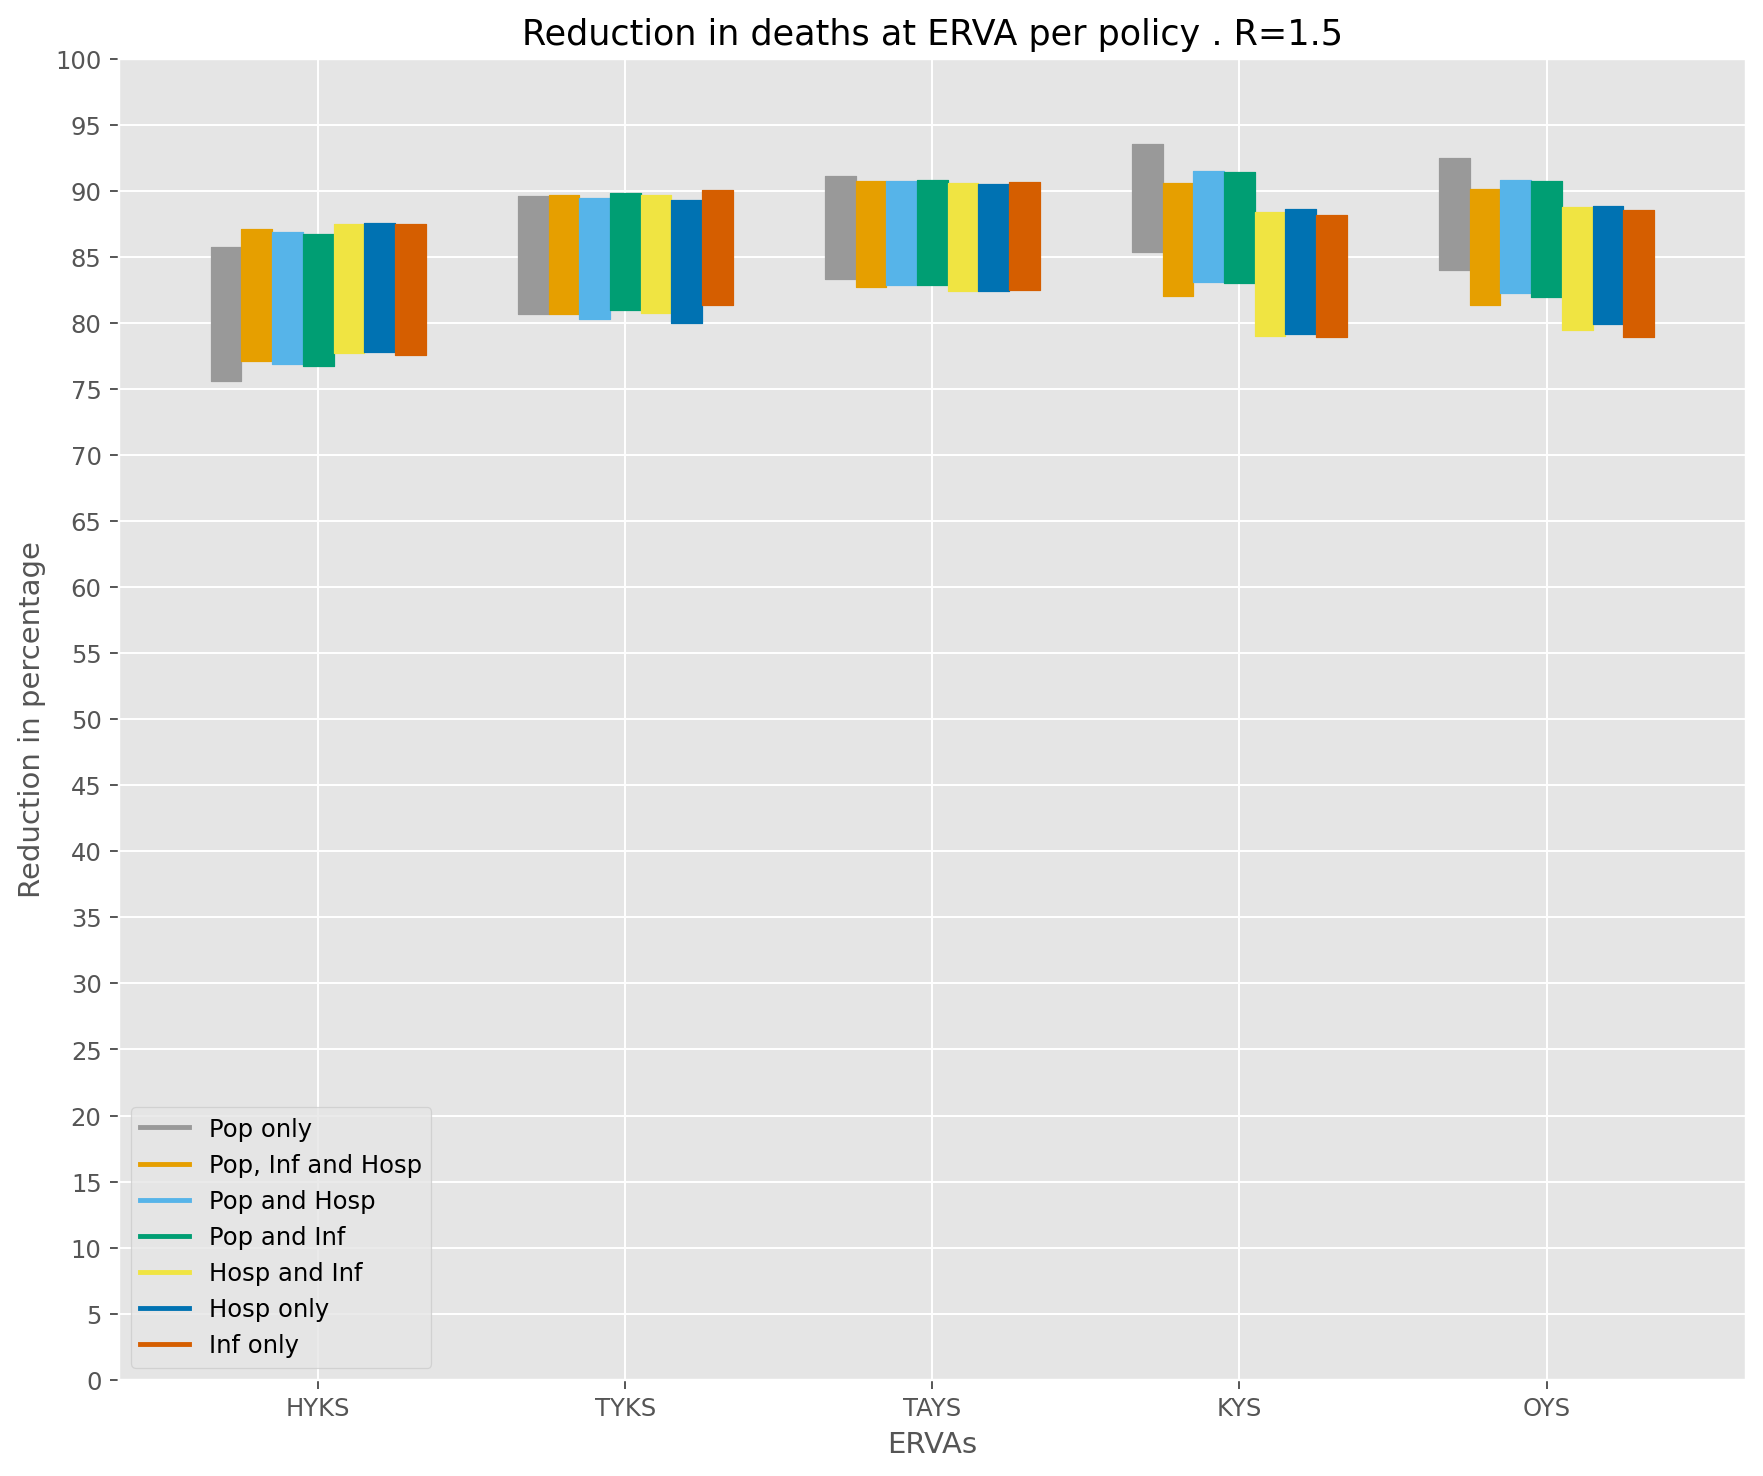

In [64]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[2], 'deaths', all_results, ervas_labels)

In [65]:
def plot_age_groups(ax, results_all_metrics, t0, T, age_labels, metric):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    main_label, metric_results = results_all_metrics
    results = metric_results[metric]
    num_ages, num_ervas, days = results.shape
    assert num_ages == len(age_labels)

    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    results_age_groups = results.sum(axis=1)
    assert results_ervas.shape[0] == num_ages
    assert results_ervas.shape[1] == T

    for age_i in range(num_ages):
        ax.plot(x, results_ervas[age_i, :], label=age_labels[age_i])

    ax.set_xlabel('Date')
    ax.set_ylabel('Number of %s' % (metric, ))
    ax.set_title('Number of %s per age group. Strategy: %s' % (metric, main_label))

    ax.legend()

    return ax

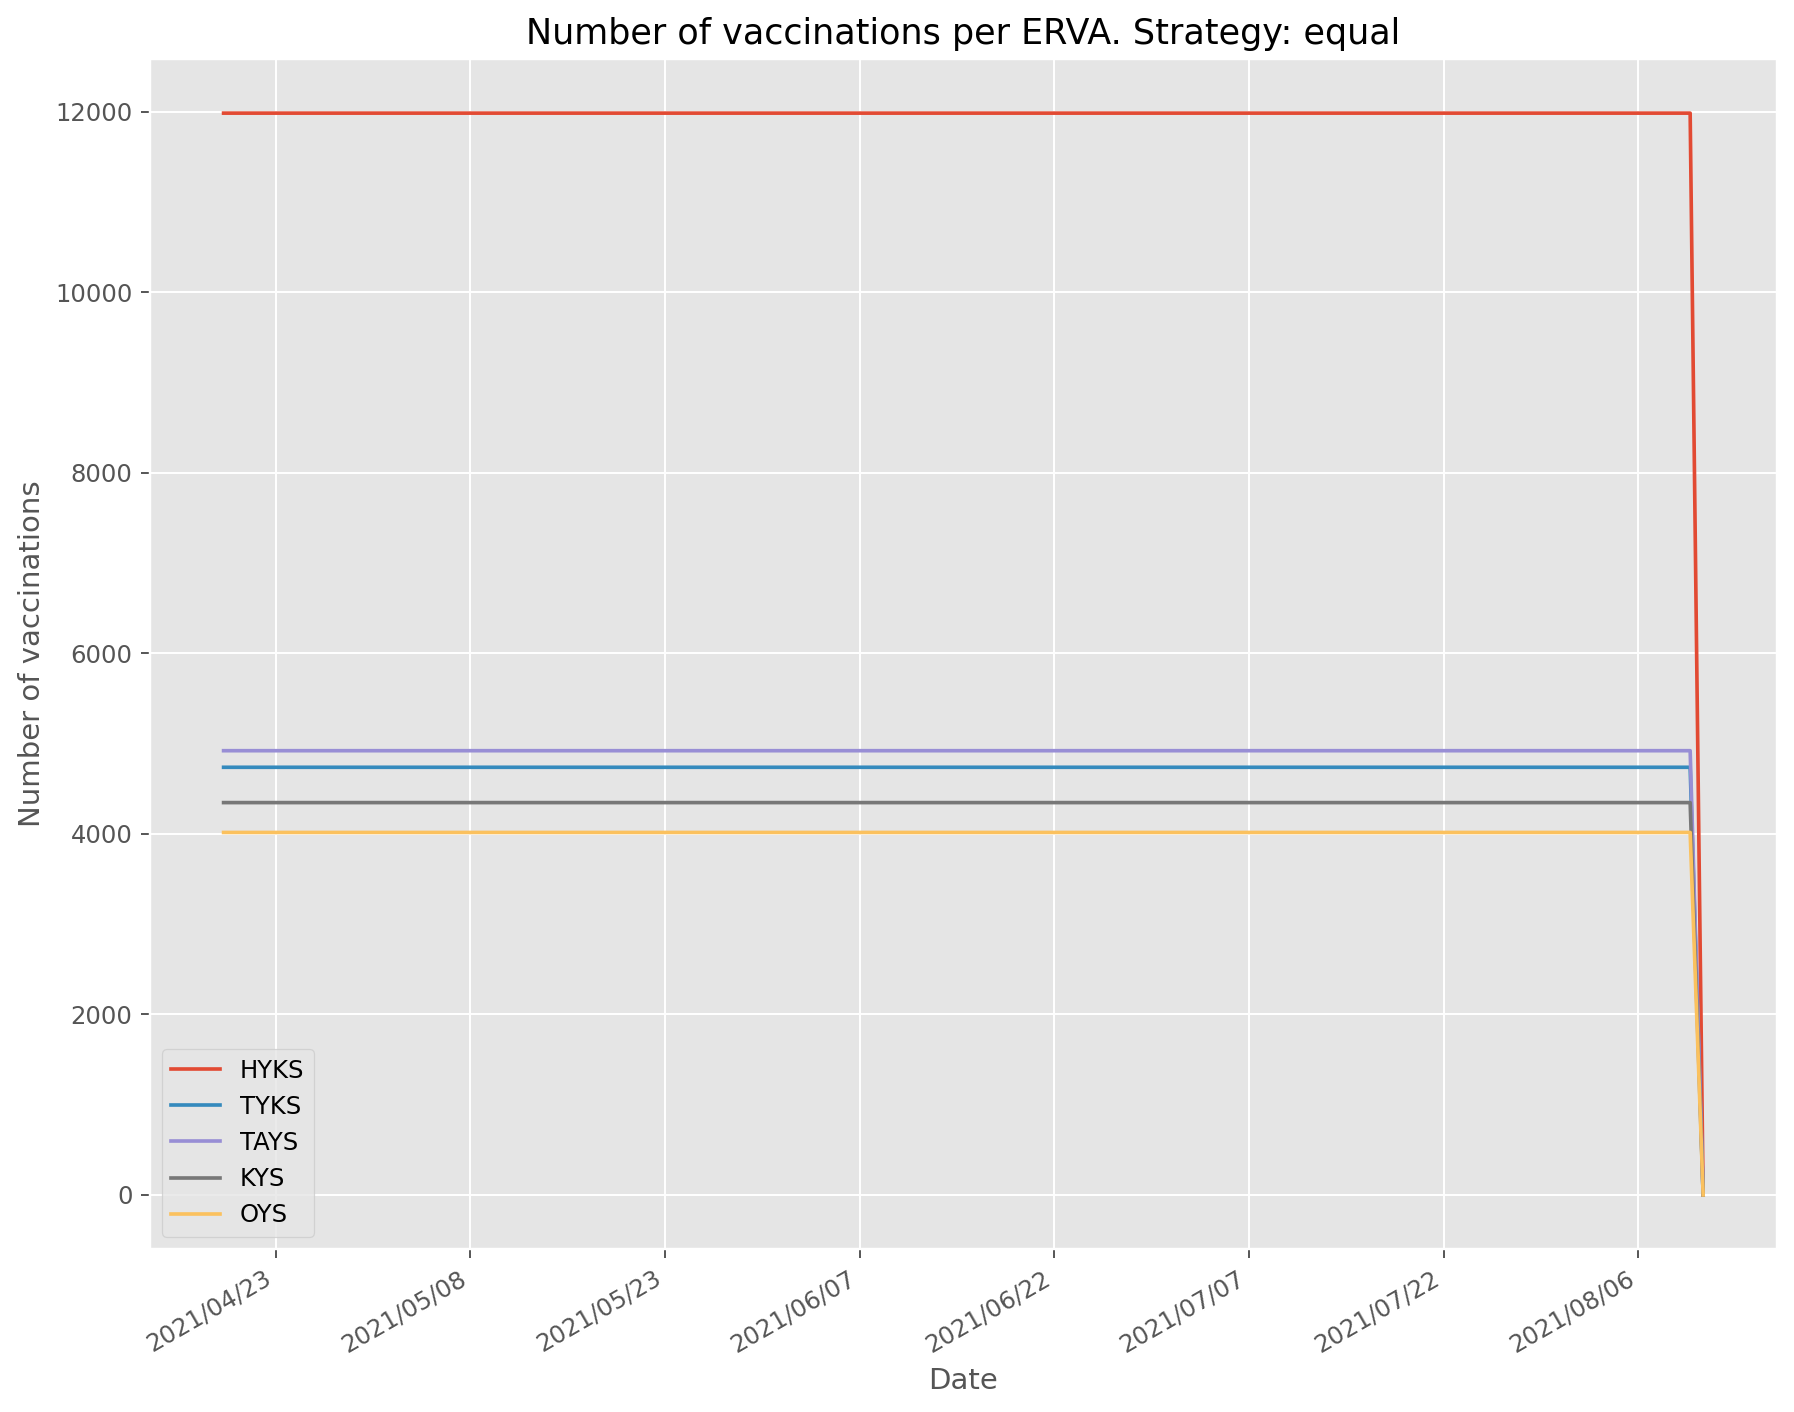

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

plot_res = all_results[r_experiments[0]][0]
ax = plot_ervas(ax=ax, results_all_metrics=plot_res, t0=t0, T=T, ervas_labels=ervas_labels, metric='vaccinations')

fig.autofmt_xdate()

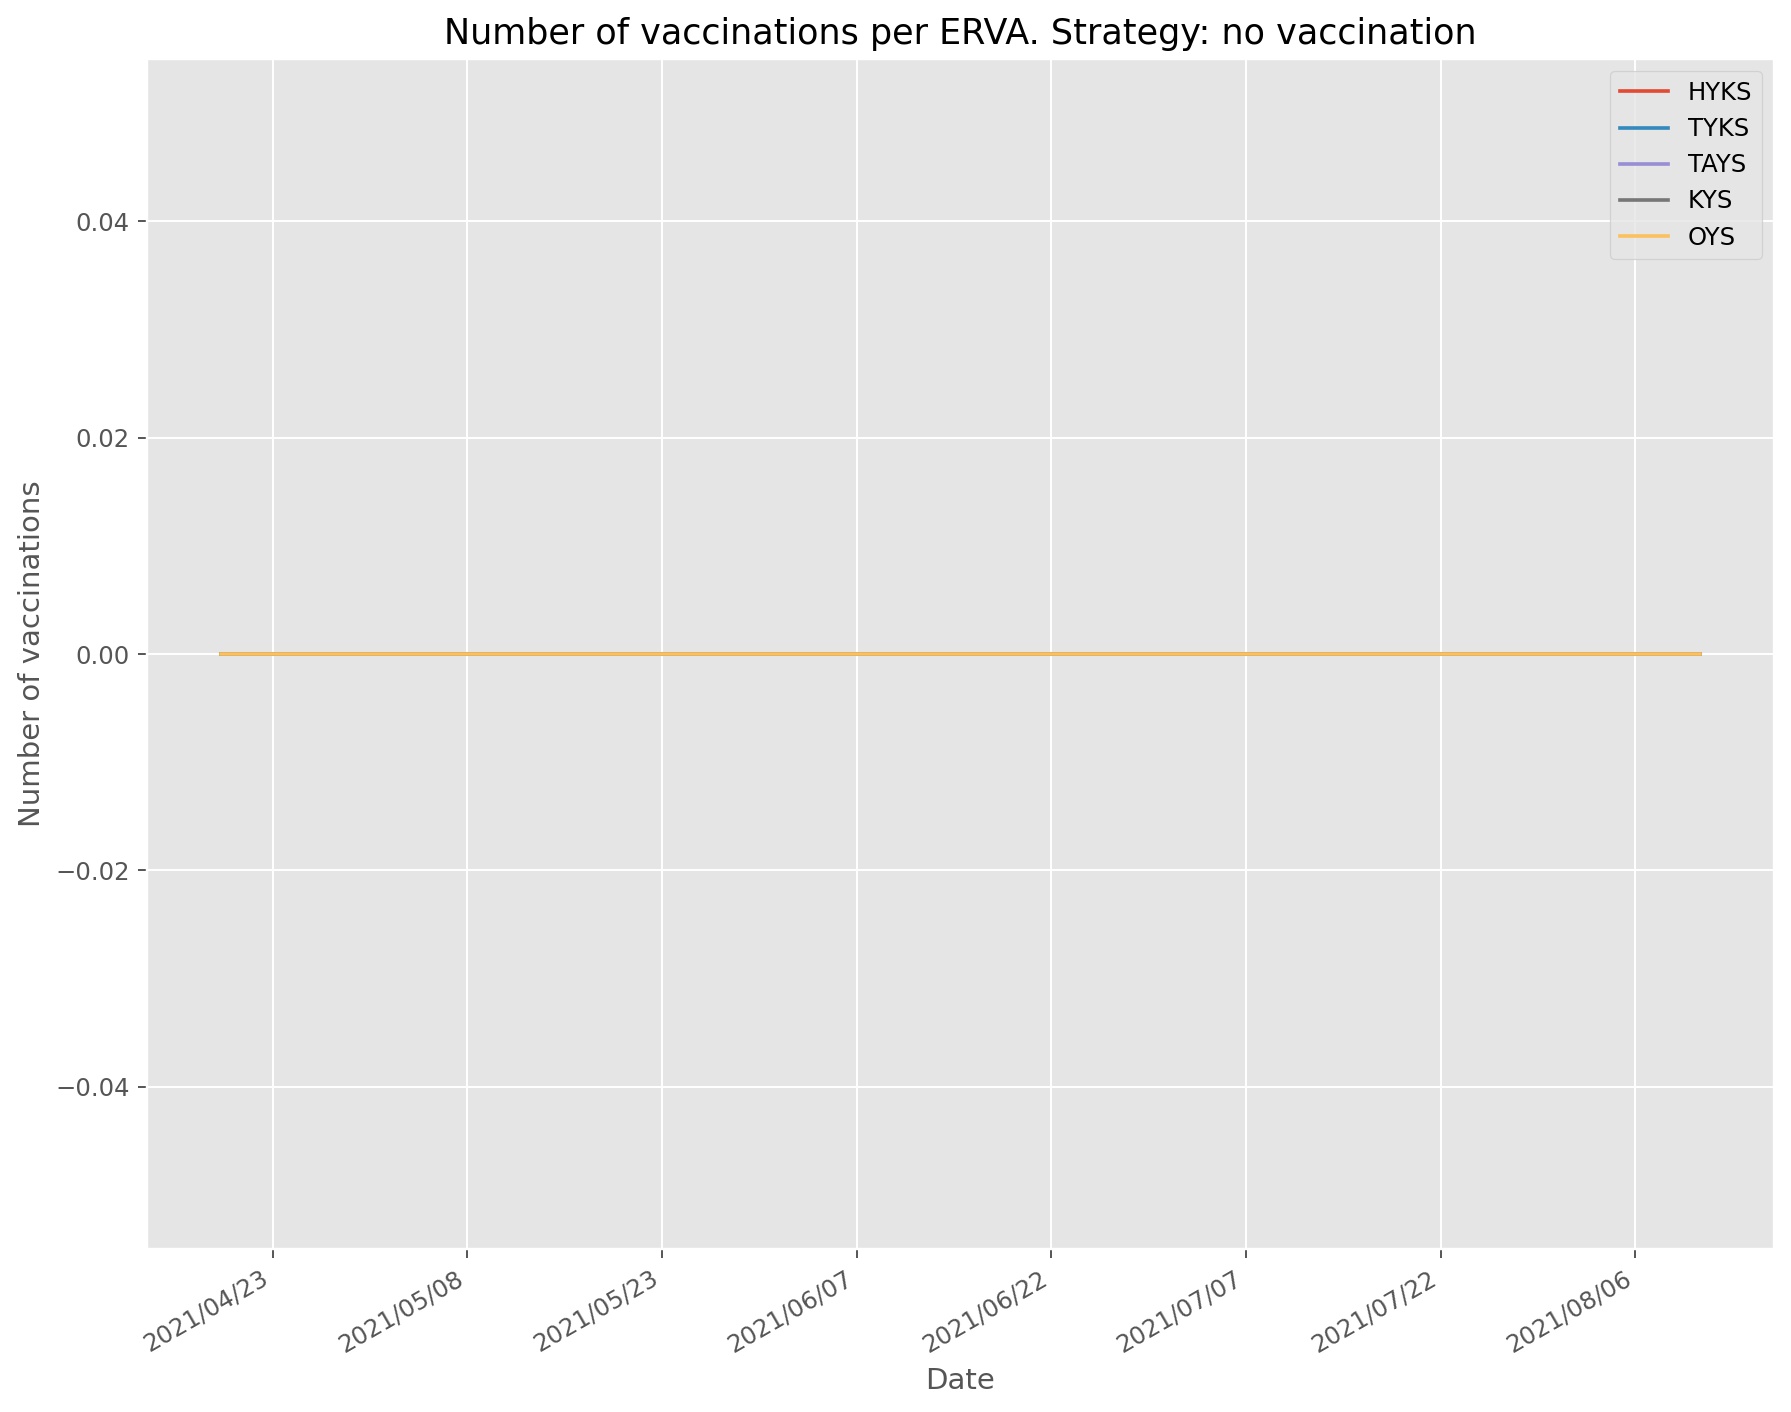

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

plot_res = all_results[r_experiments[0]][1]
ax = plot_ervas(ax=ax, results_all_metrics=plot_res, t0=t0, T=T, ervas_labels=ervas_labels, metric='vaccinations')

fig.autofmt_xdate()

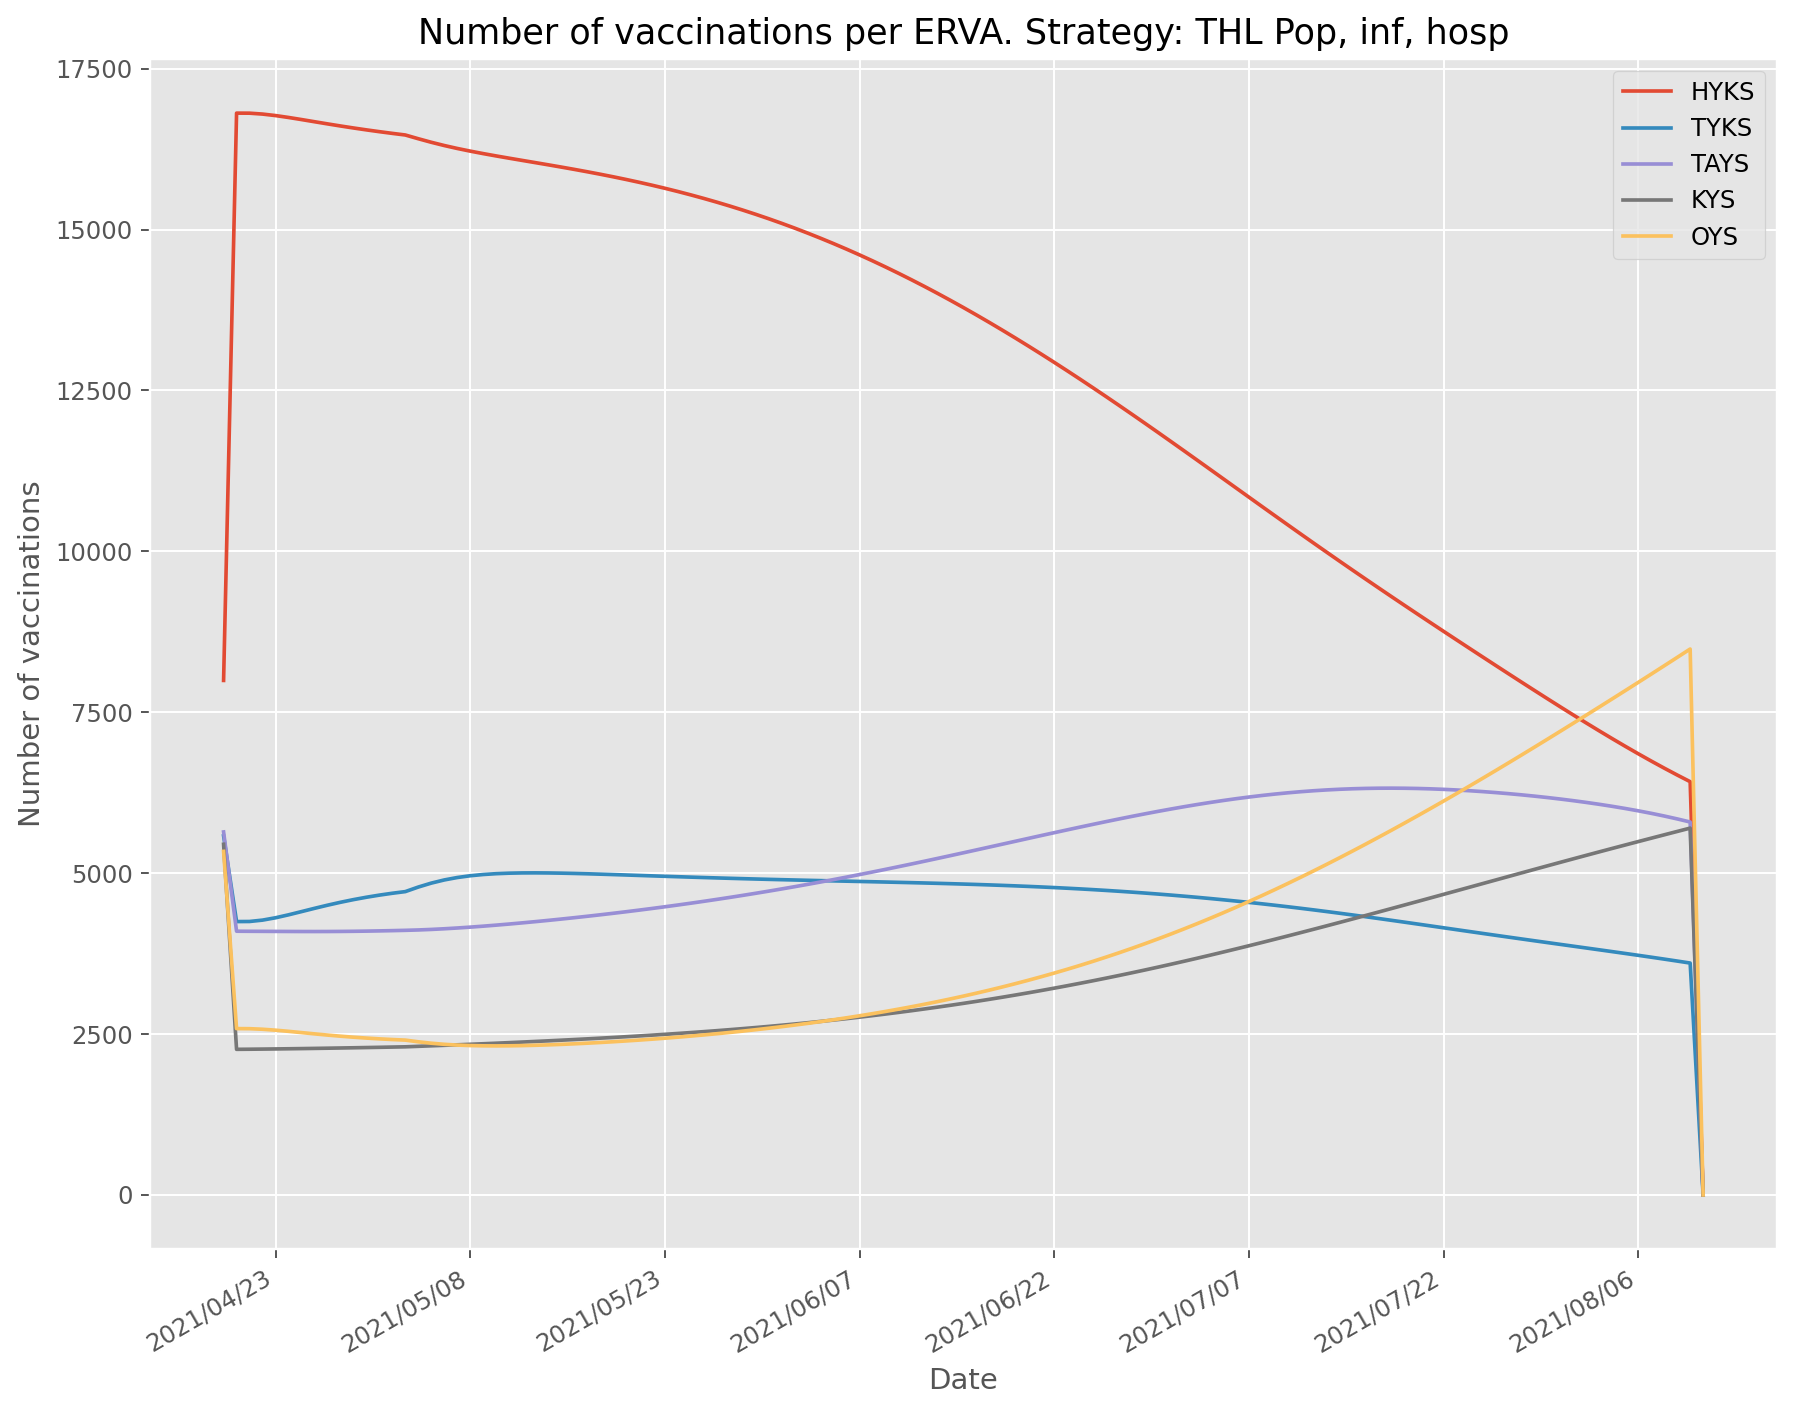

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

plot_res = all_results[r_experiments[0]][2]
ax = plot_ervas(ax=ax, results_all_metrics=plot_res, t0=t0, T=T, ervas_labels=ervas_labels, metric='vaccinations')

fig.autofmt_xdate()

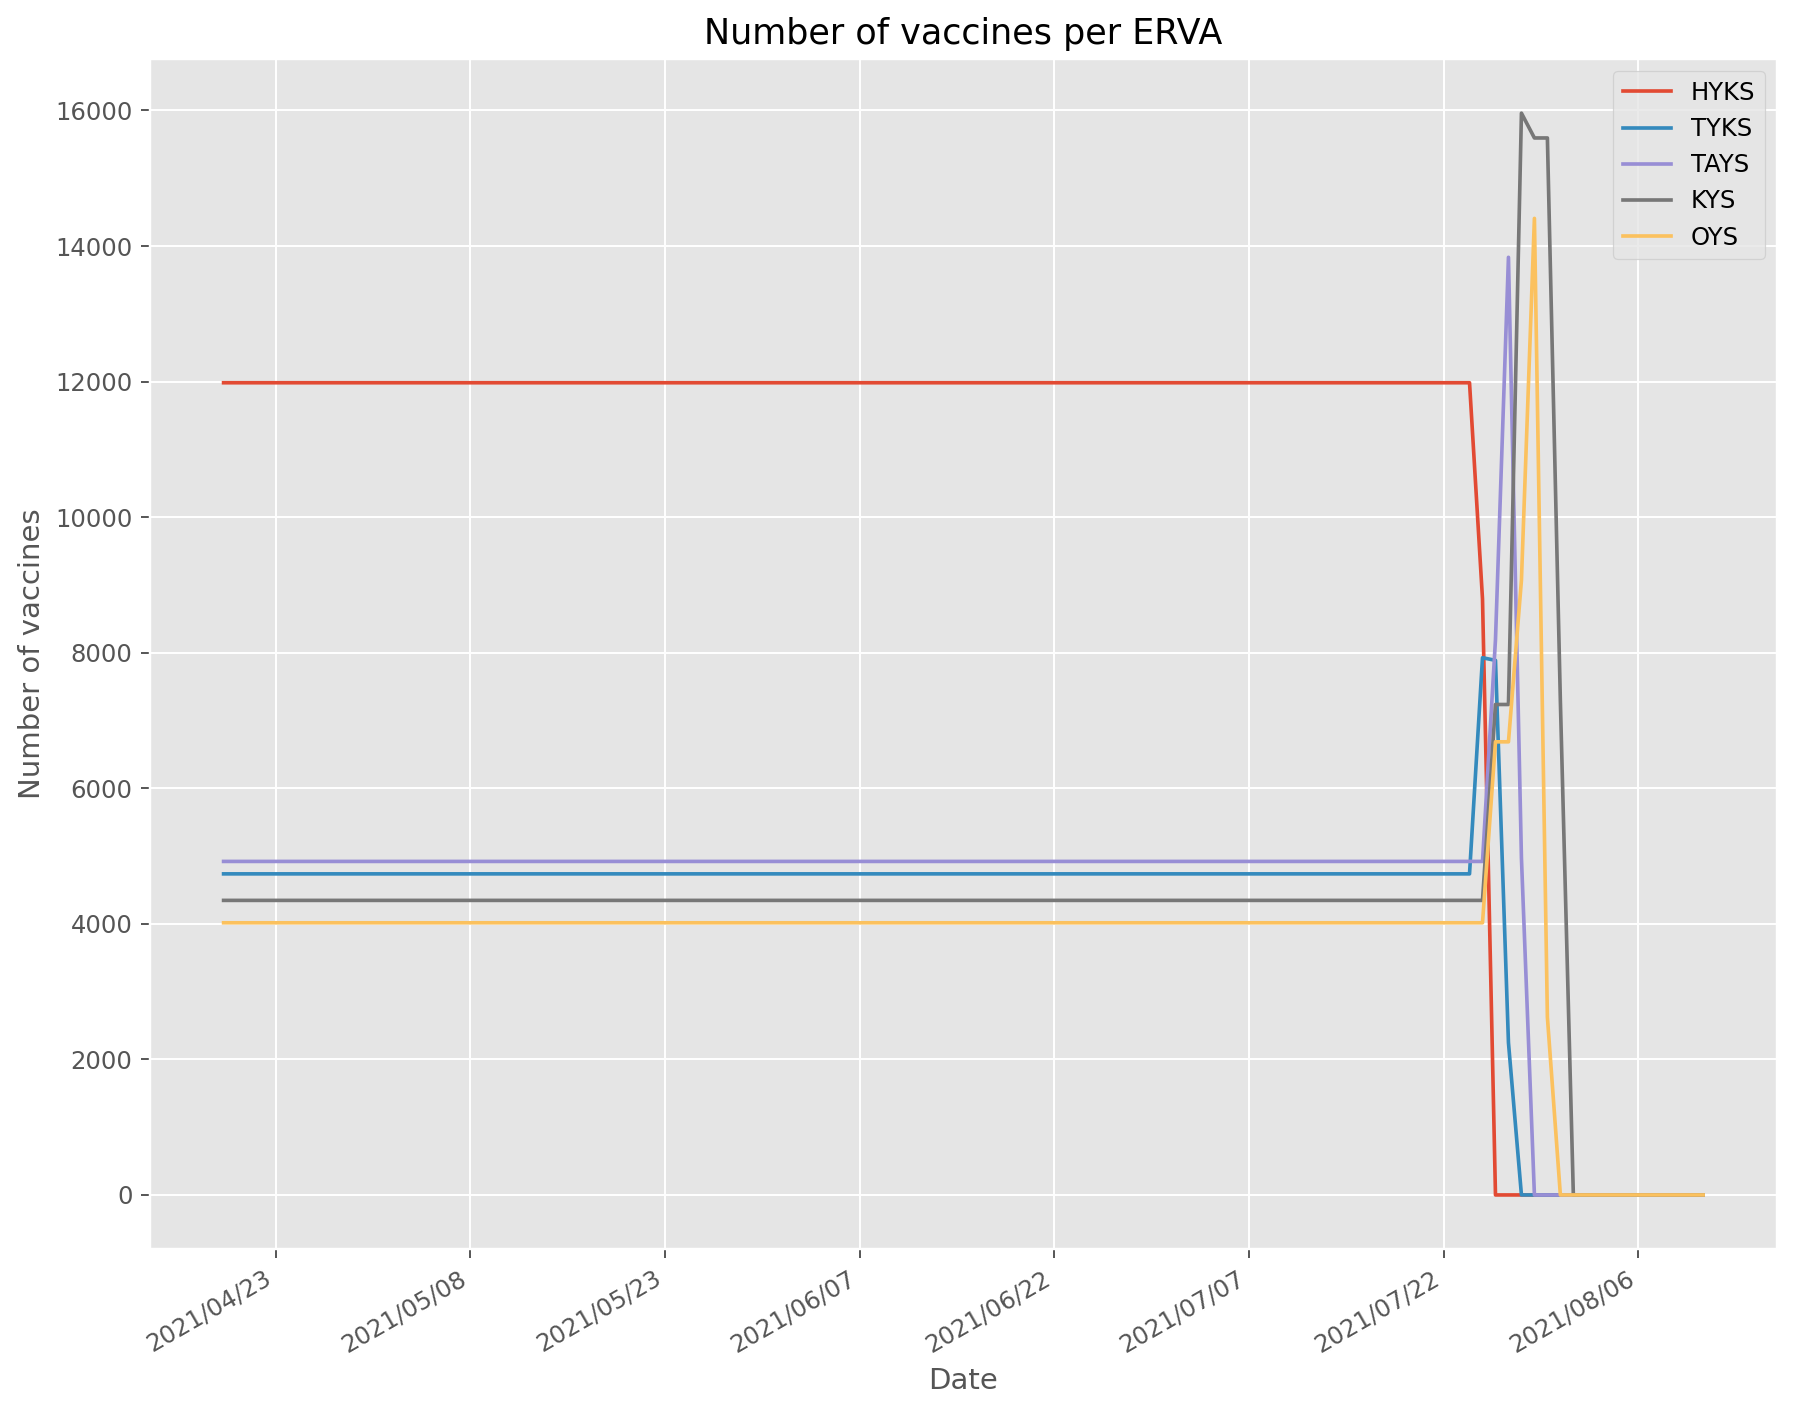

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=u_g_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='vaccines')

fig.autofmt_xdate()

In [9]:
policy = 'thl'

_, _, _, _, _, D_g_thl, u_g_thl = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0, policy)

age_er_prop = age_er.T
age_er_prop = age_er_prop[:, :, np.newaxis]
D_g_thl_plot = D_g_thl*age_er_prop
u_g_thl_plot = u_g_thl*age_er_prop

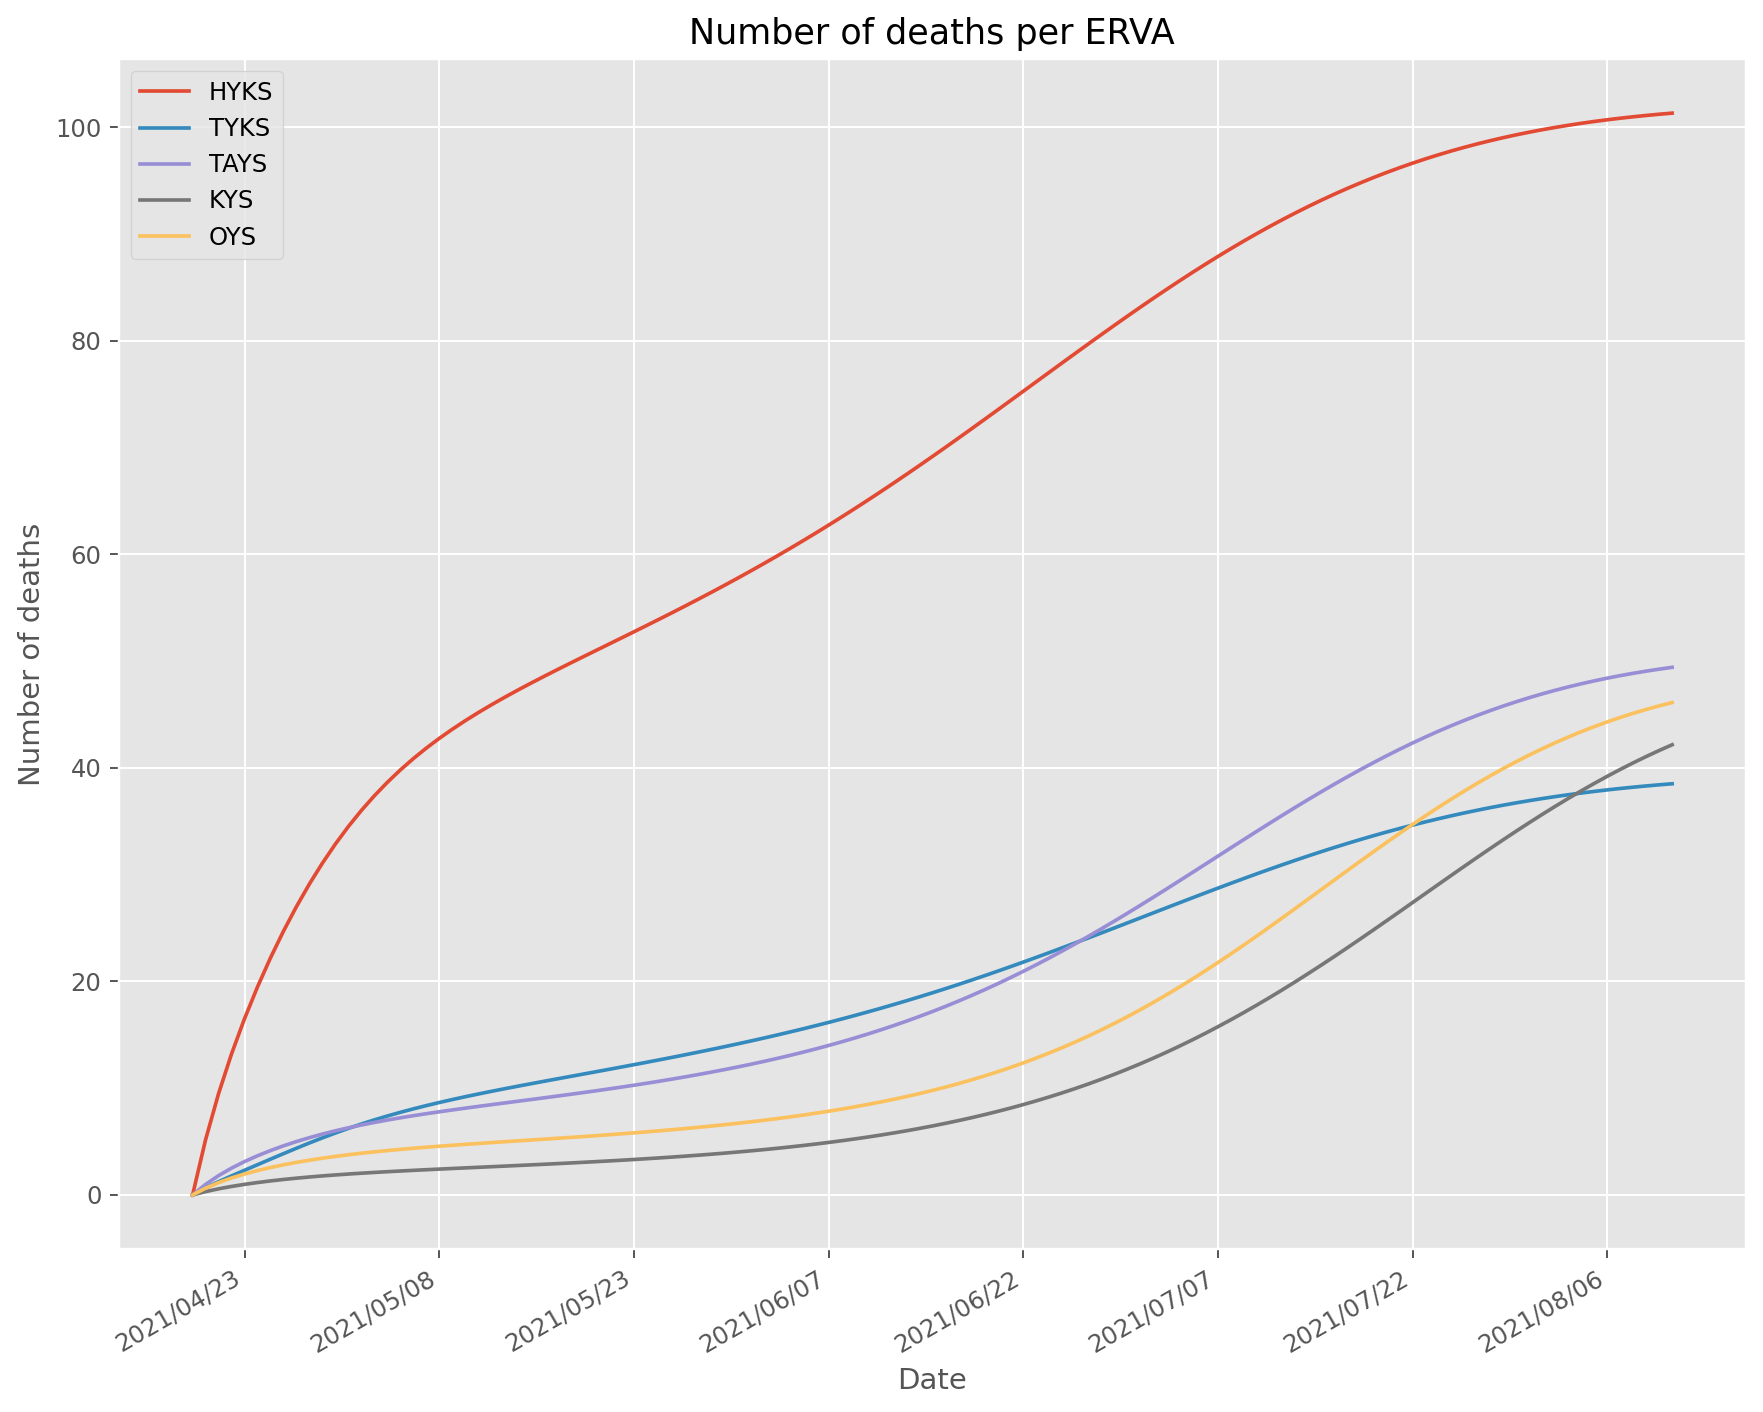

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=D_g_thl_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='deaths')

fig.autofmt_xdate()

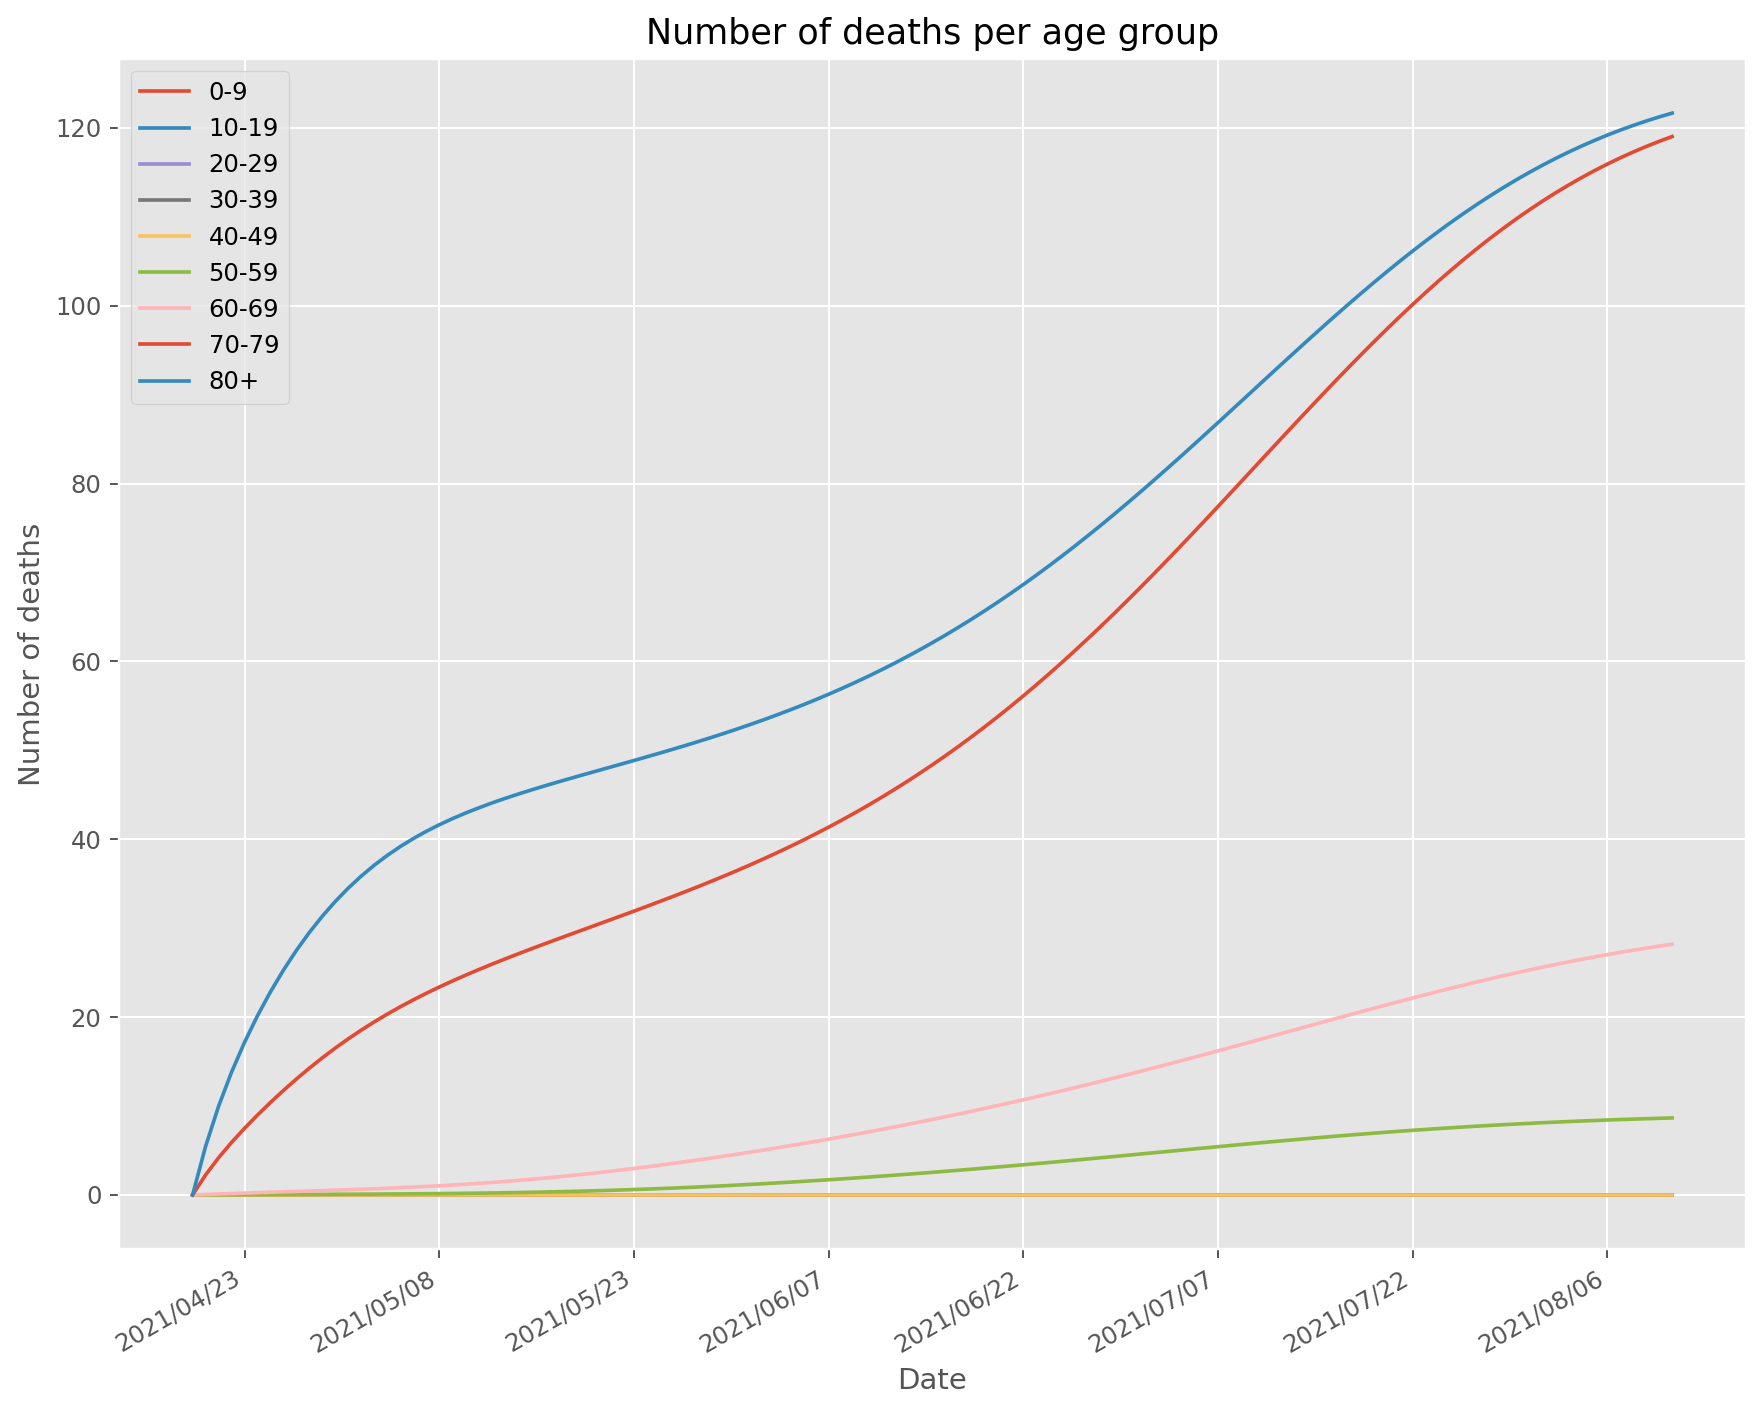

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=D_g_thl_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='deaths')

fig.autofmt_xdate()

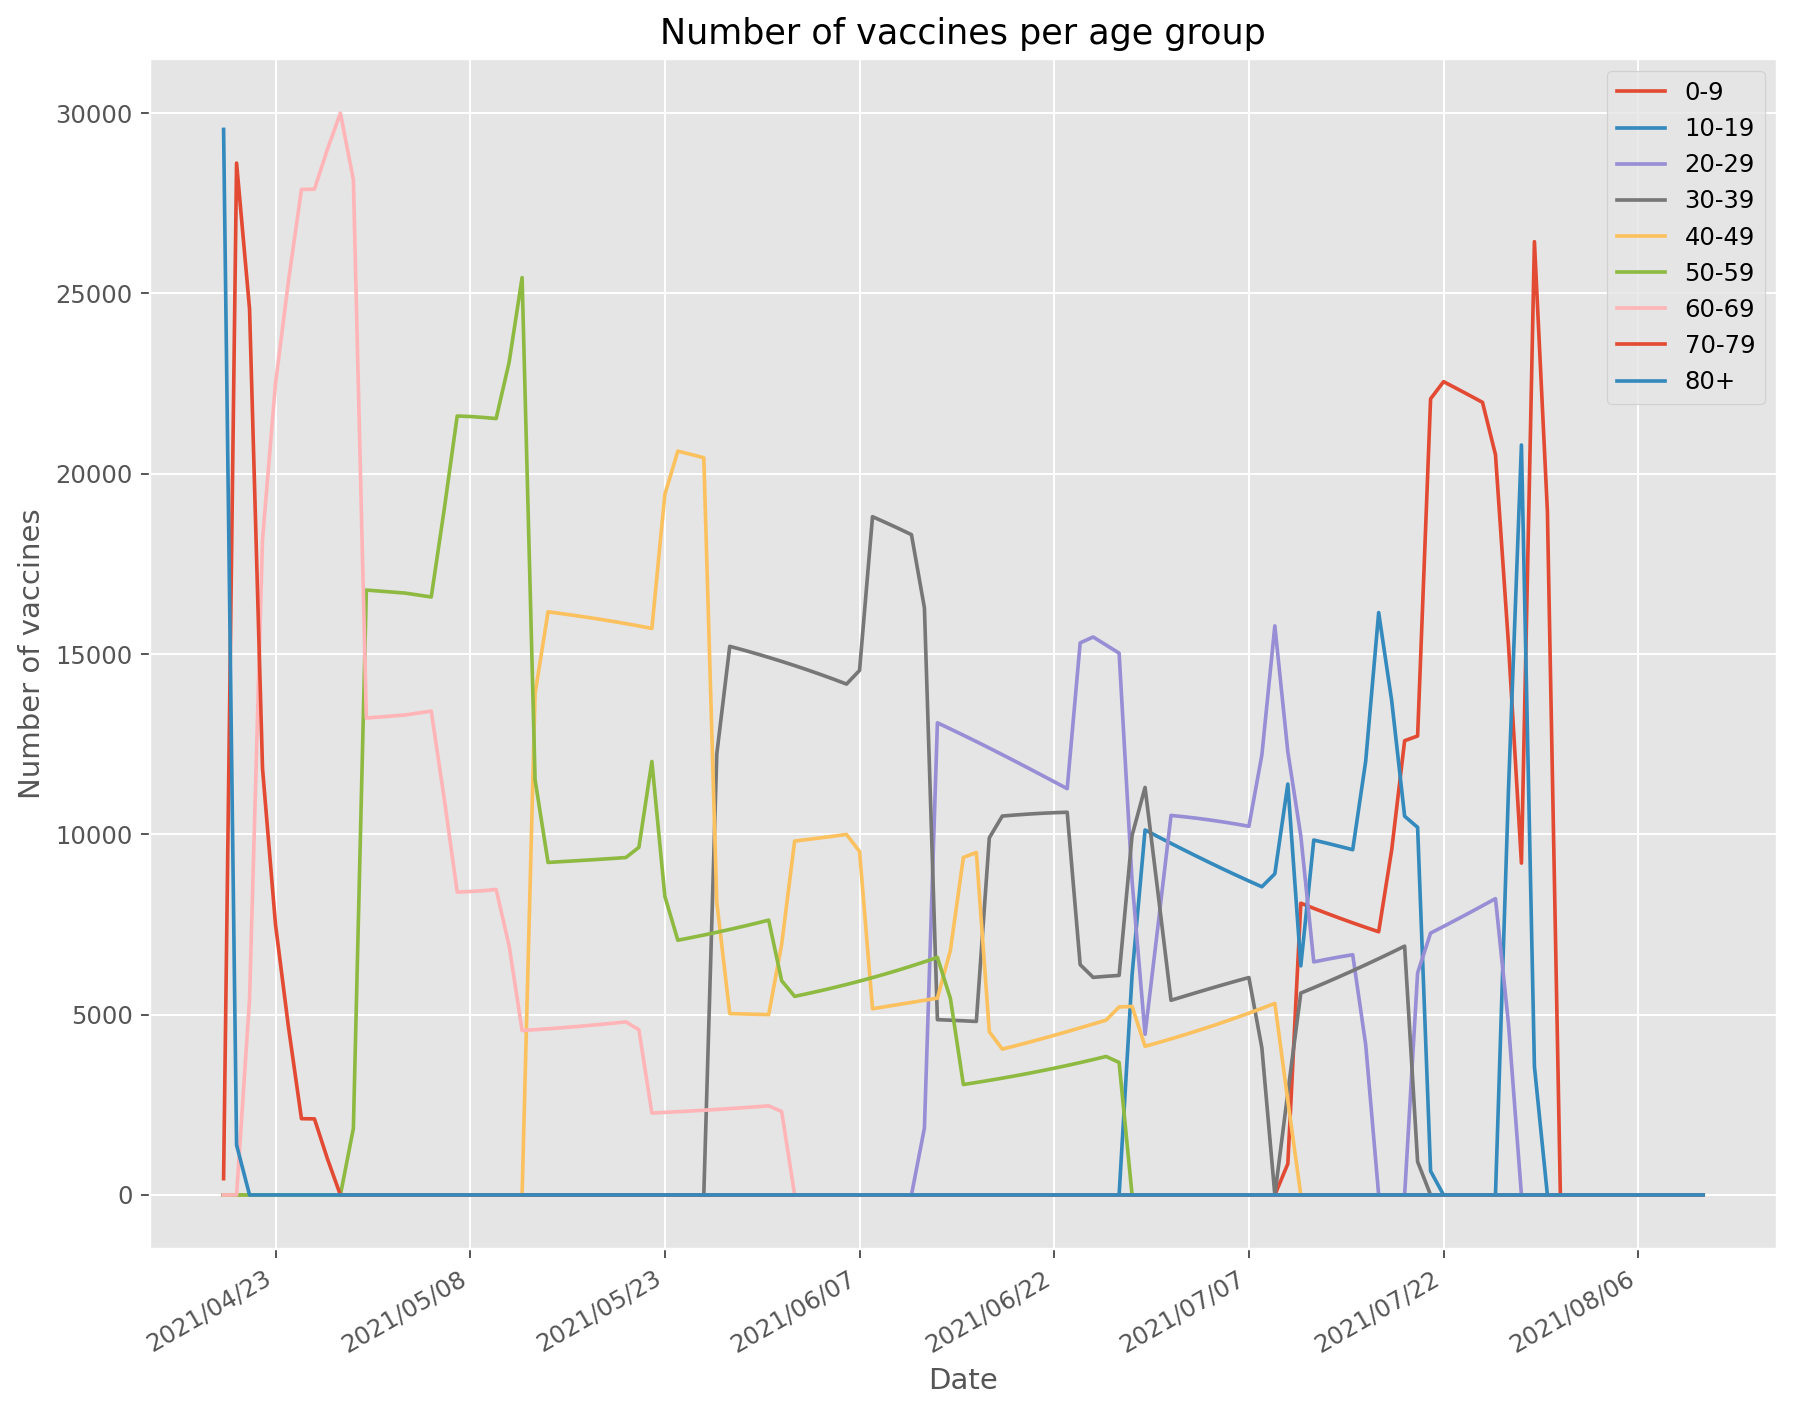

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=u_g_thl_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='vaccines')

fig.autofmt_xdate()

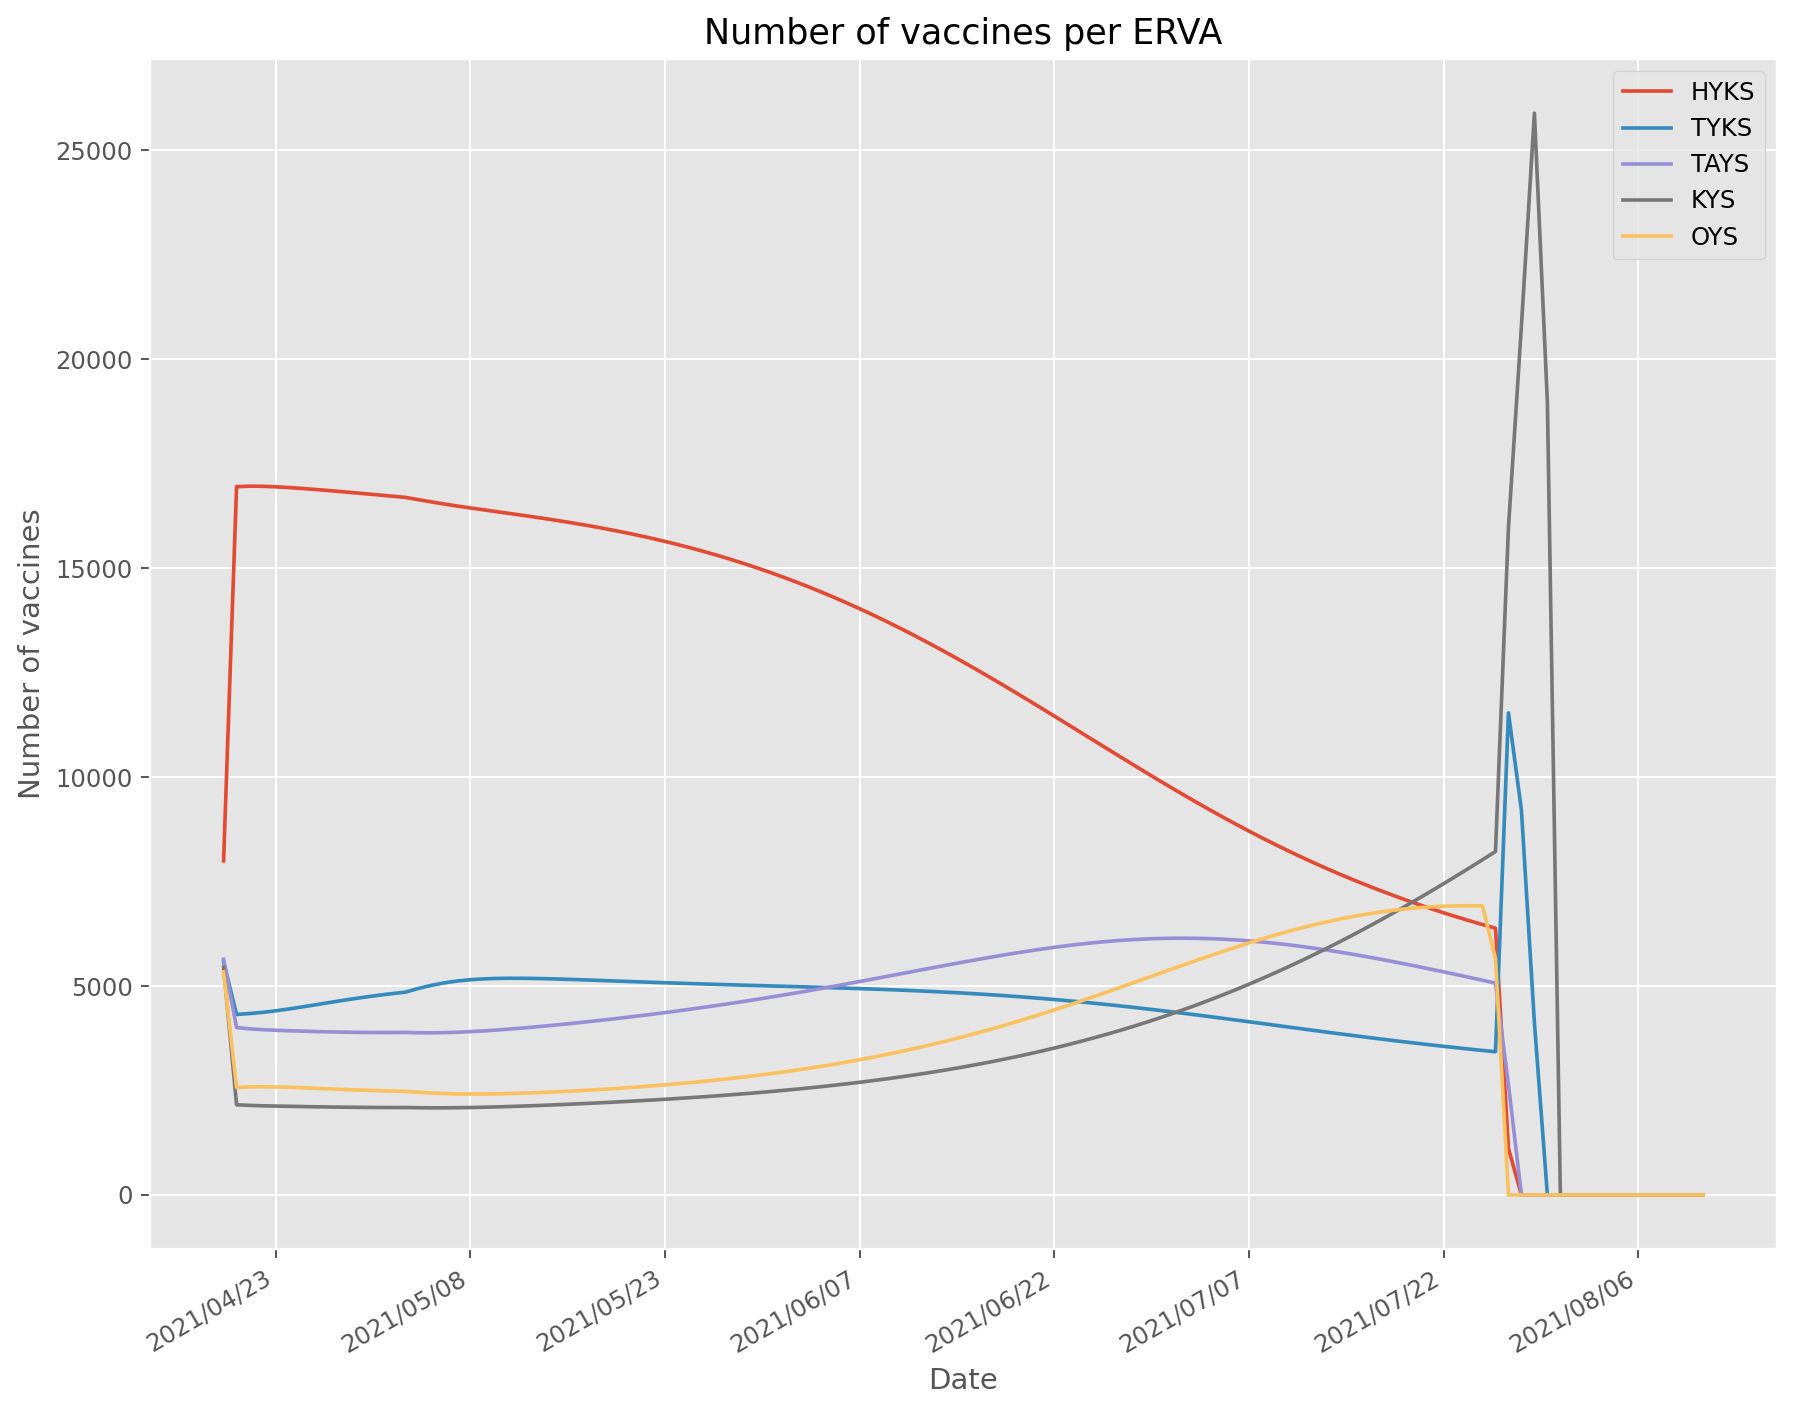

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=u_g_thl_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='vaccines')

fig.autofmt_xdate()

In [14]:
policy = 'no_vacc'

_, _, _, _, _, D_g_no, u_g_no = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0, policy)

age_er_prop = age_er.T
age_er_prop = age_er_prop[:, :, np.newaxis]
D_g_no_plot = D_g_no*age_er_prop
u_g_no_plot = u_g_no*age_er_prop

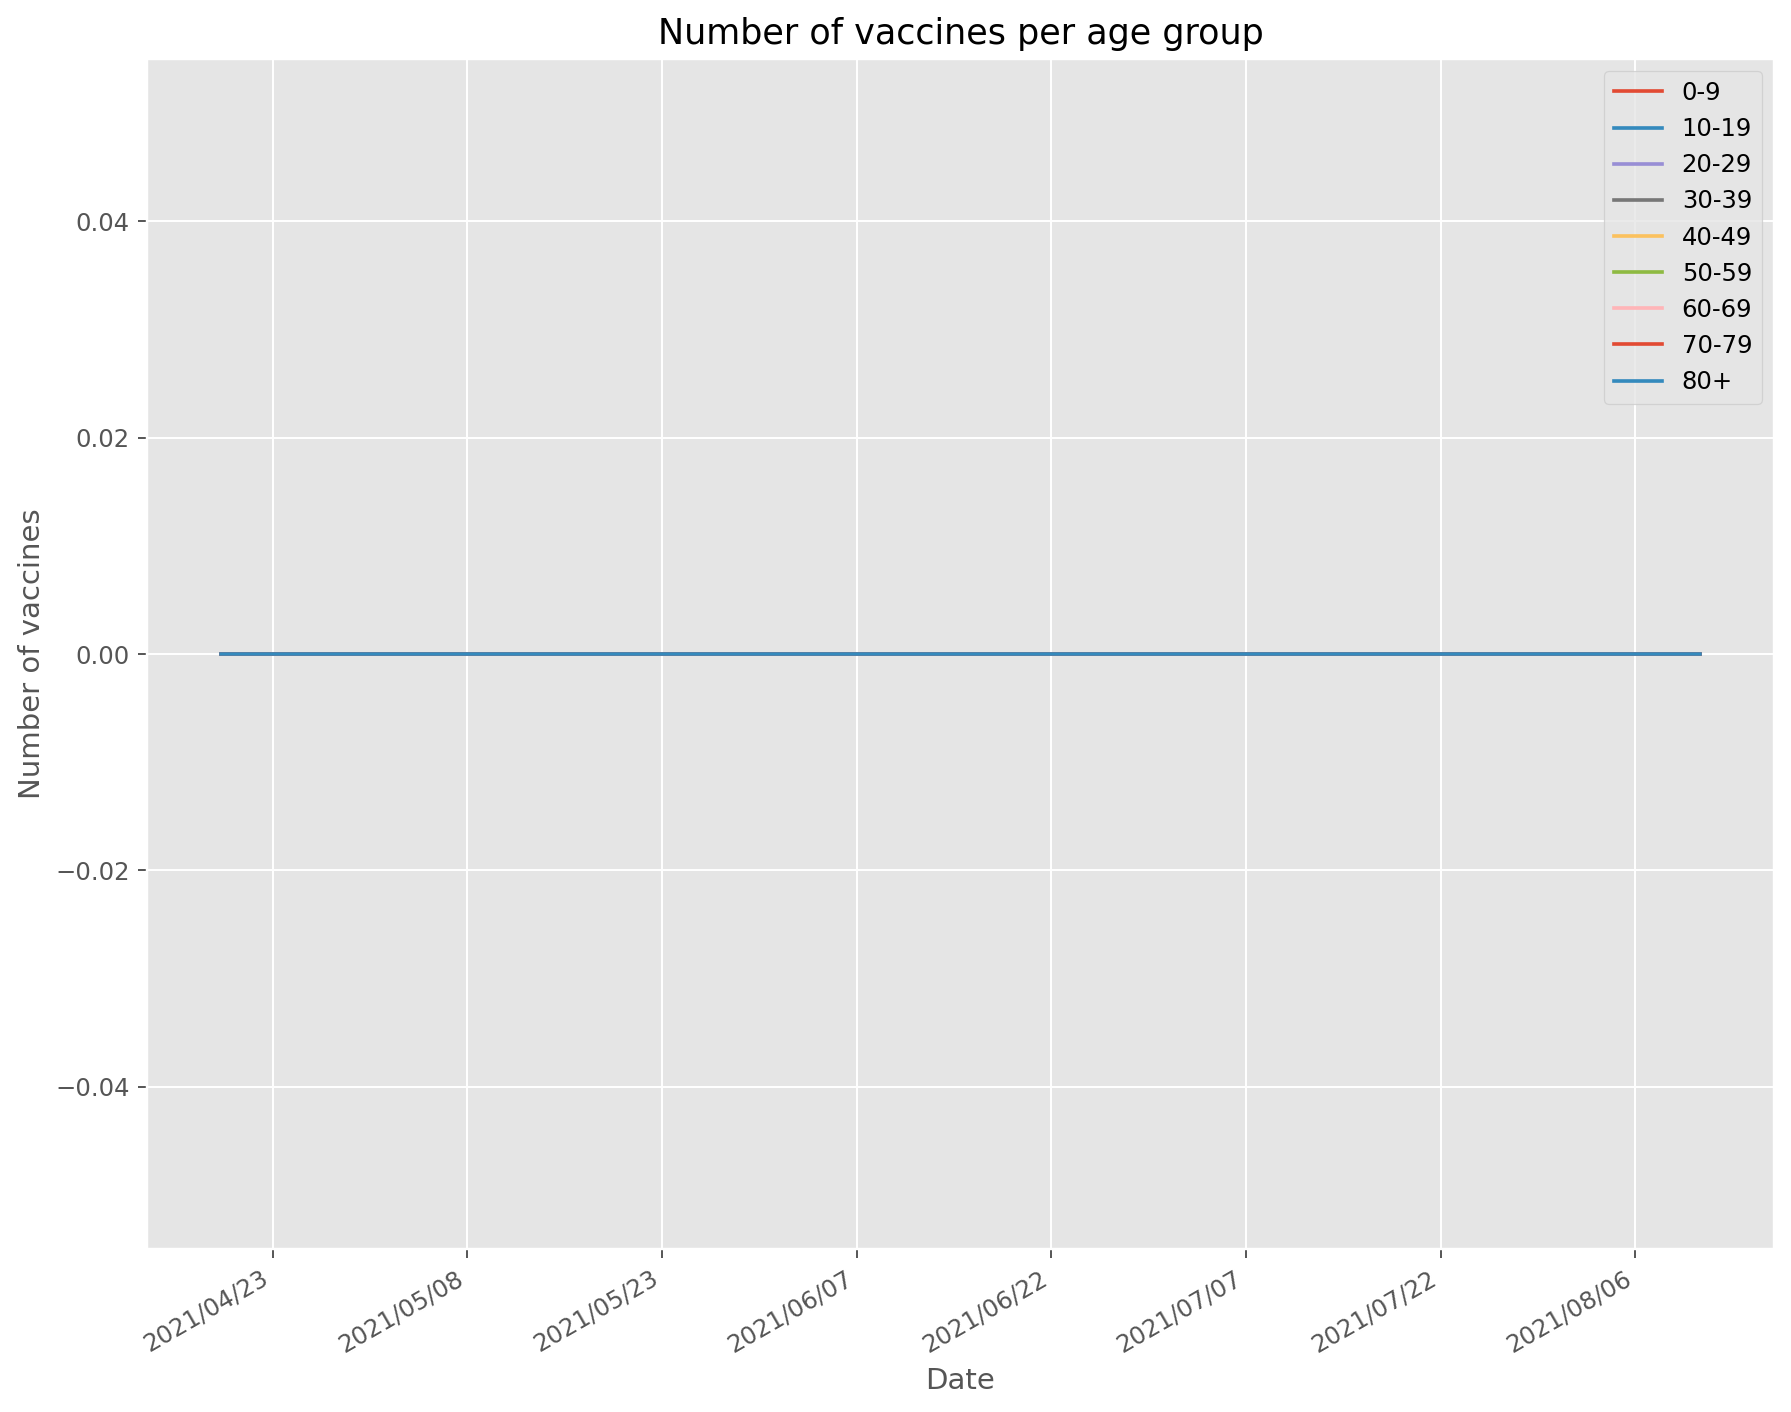

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=u_g_no_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='vaccines')

fig.autofmt_xdate()

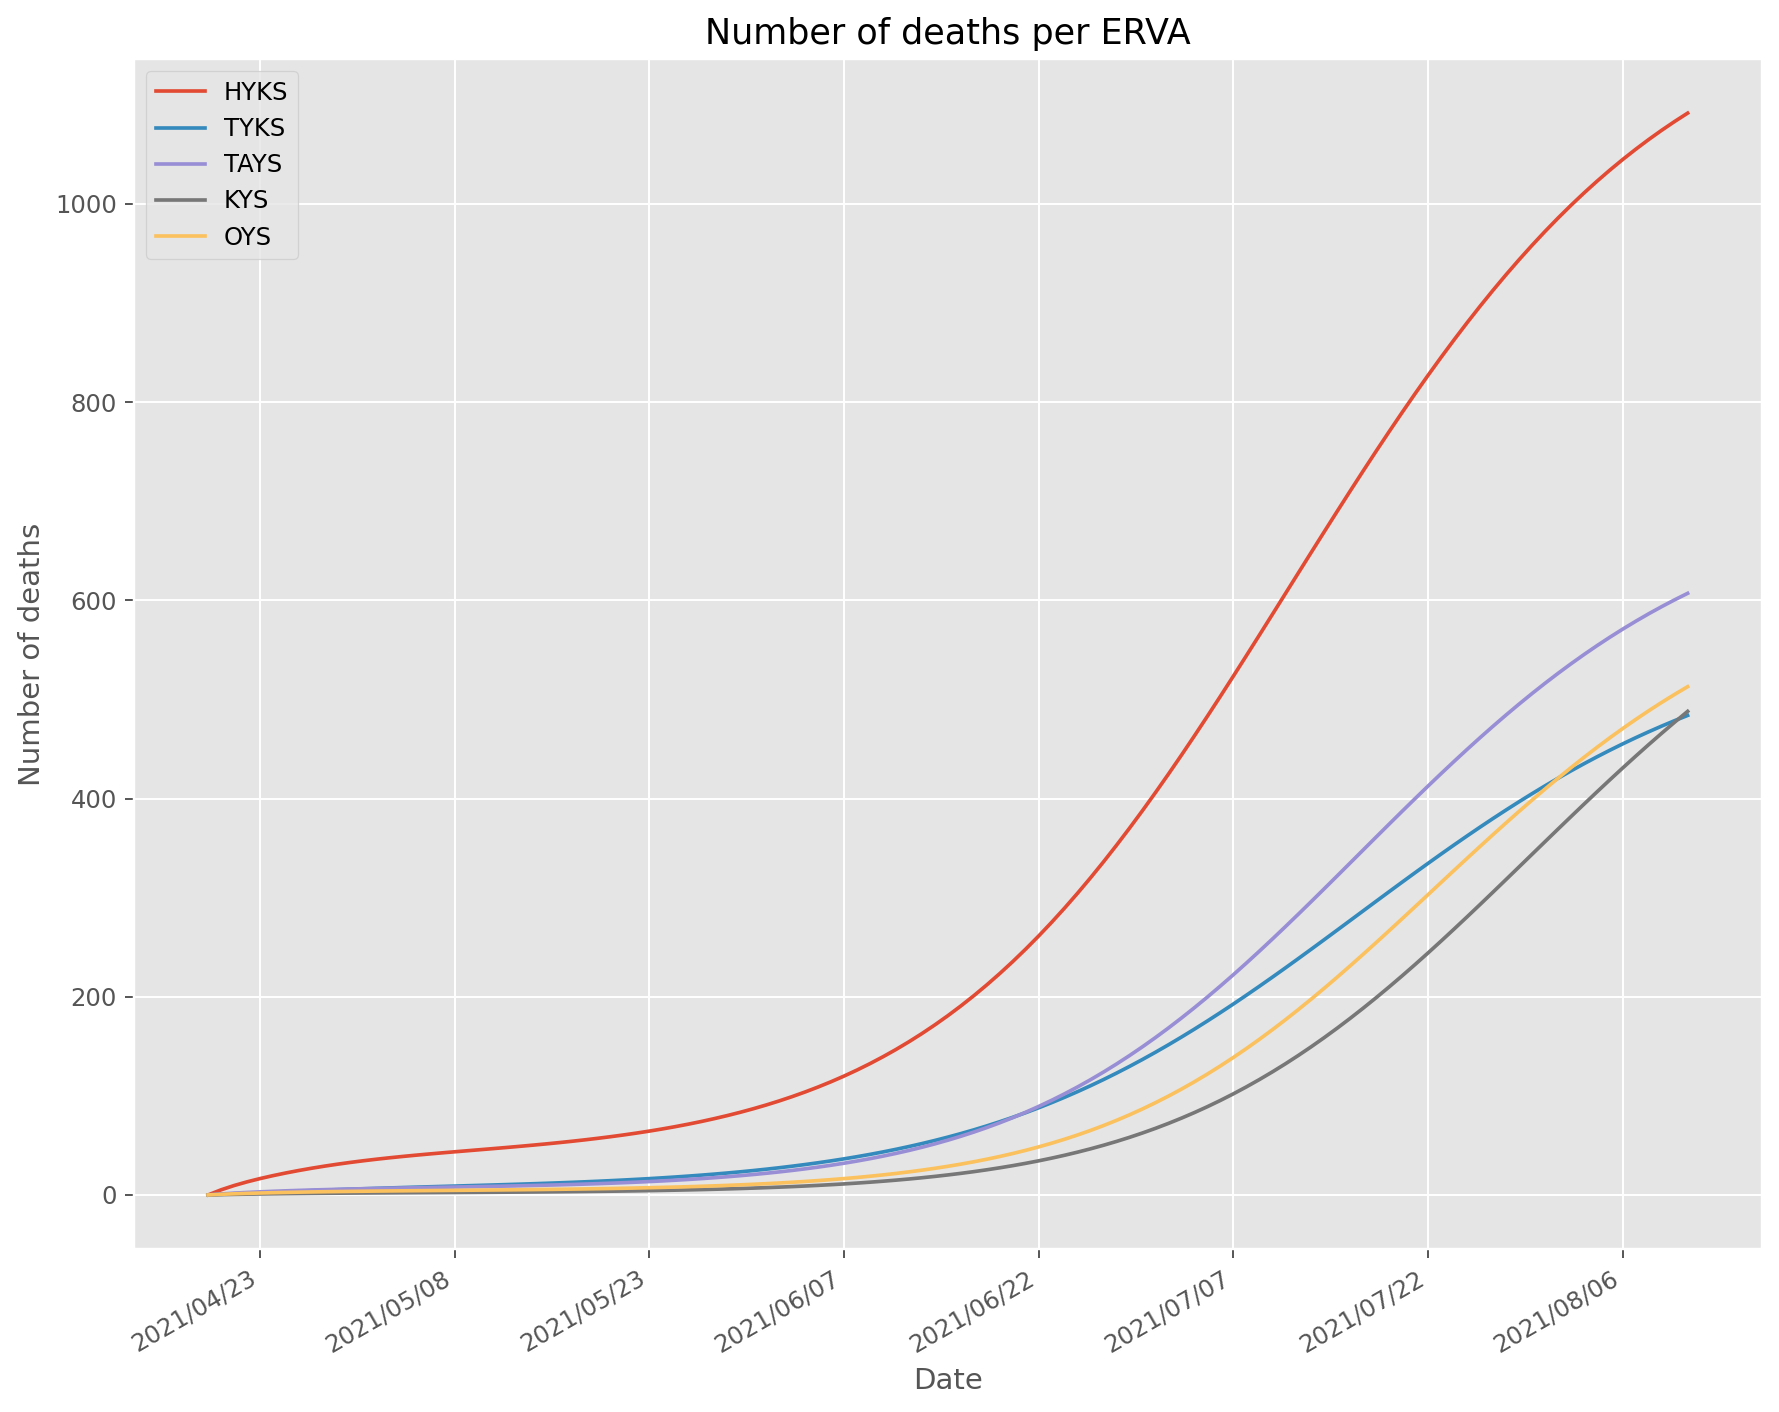

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=D_g_no_plot, t0=t0, T=T, ervas_labels=ervas_labels, plot_subject='deaths')

fig.autofmt_xdate()

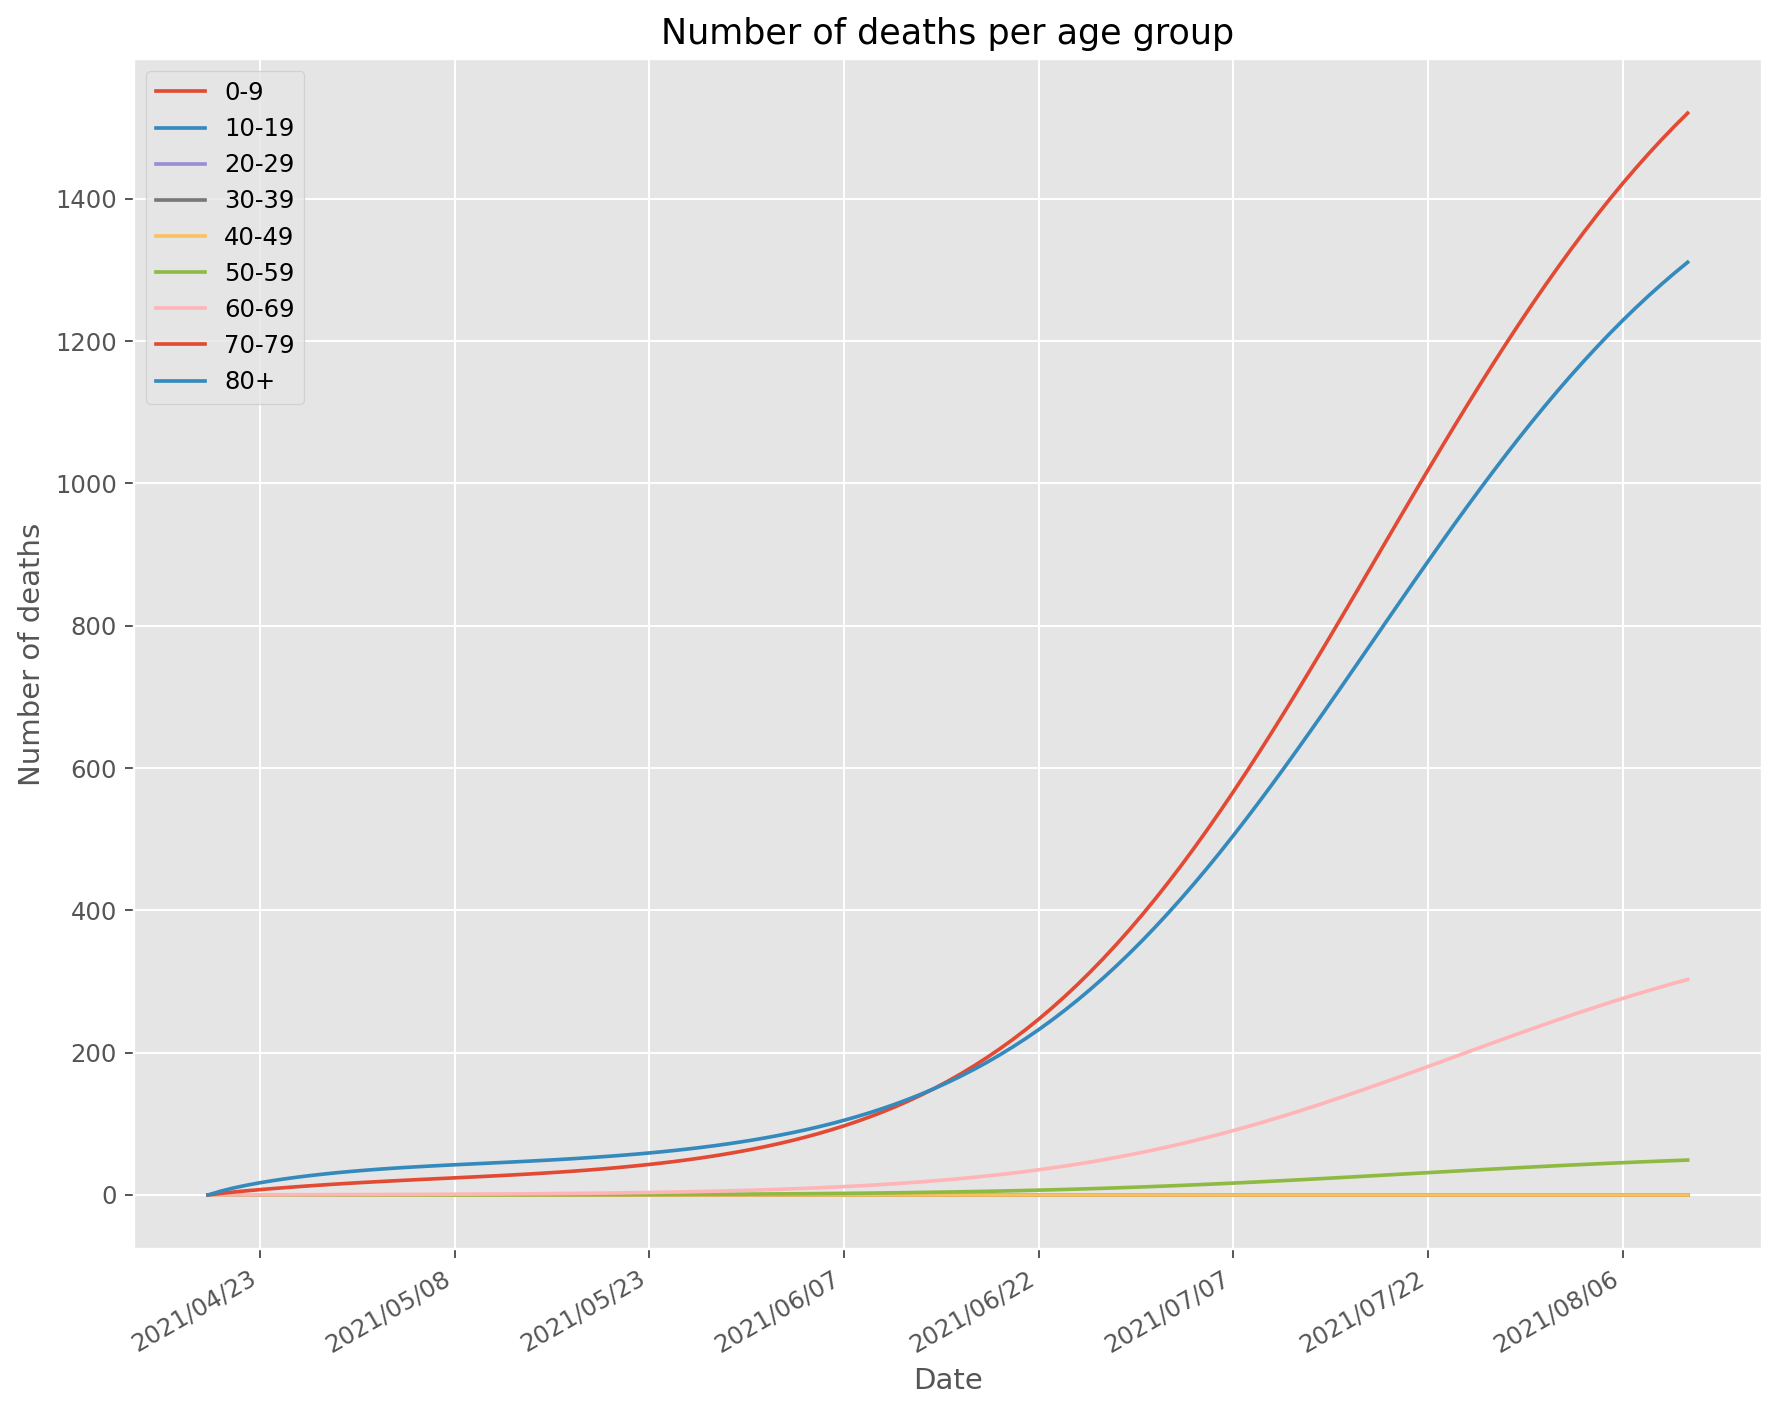

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=D_g_no_plot, t0=t0, T=T, age_labels=age_labels, plot_subject='deaths')

fig.autofmt_xdate()

In [18]:
def plot_compare_strategies(ax, D_g, D_g_thl, D_g_no_plot, t0, T):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ages == len(age_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    
    deaths = D_g.sum(axis=1)
    deaths = deaths.sum(axis=0)
    
    deaths_thl = D_g_thl.sum(axis=1)
    deaths_thl = deaths_thl.sum(axis=0)
    
    deaths_no = D_g_no_plot.sum(axis=1)
    deaths_no = deaths_no.sum(axis=0)
    
    assert deaths.shape == deaths_thl.shape
    assert deaths.shape == deaths_no.shape
    assert deaths.shape[0] == T
    
    ax.plot(x, deaths, label='Number of vaccines proportional to population')
    ax.plot(x, deaths_thl, label='THL strategy. Weighted sum')
    ax.plot(x, deaths_no, label='No vaccination.')
    
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of deaths')
    ax.set_title('Comparing vaccination strategies')
        
    ax.legend()
    
    return ax

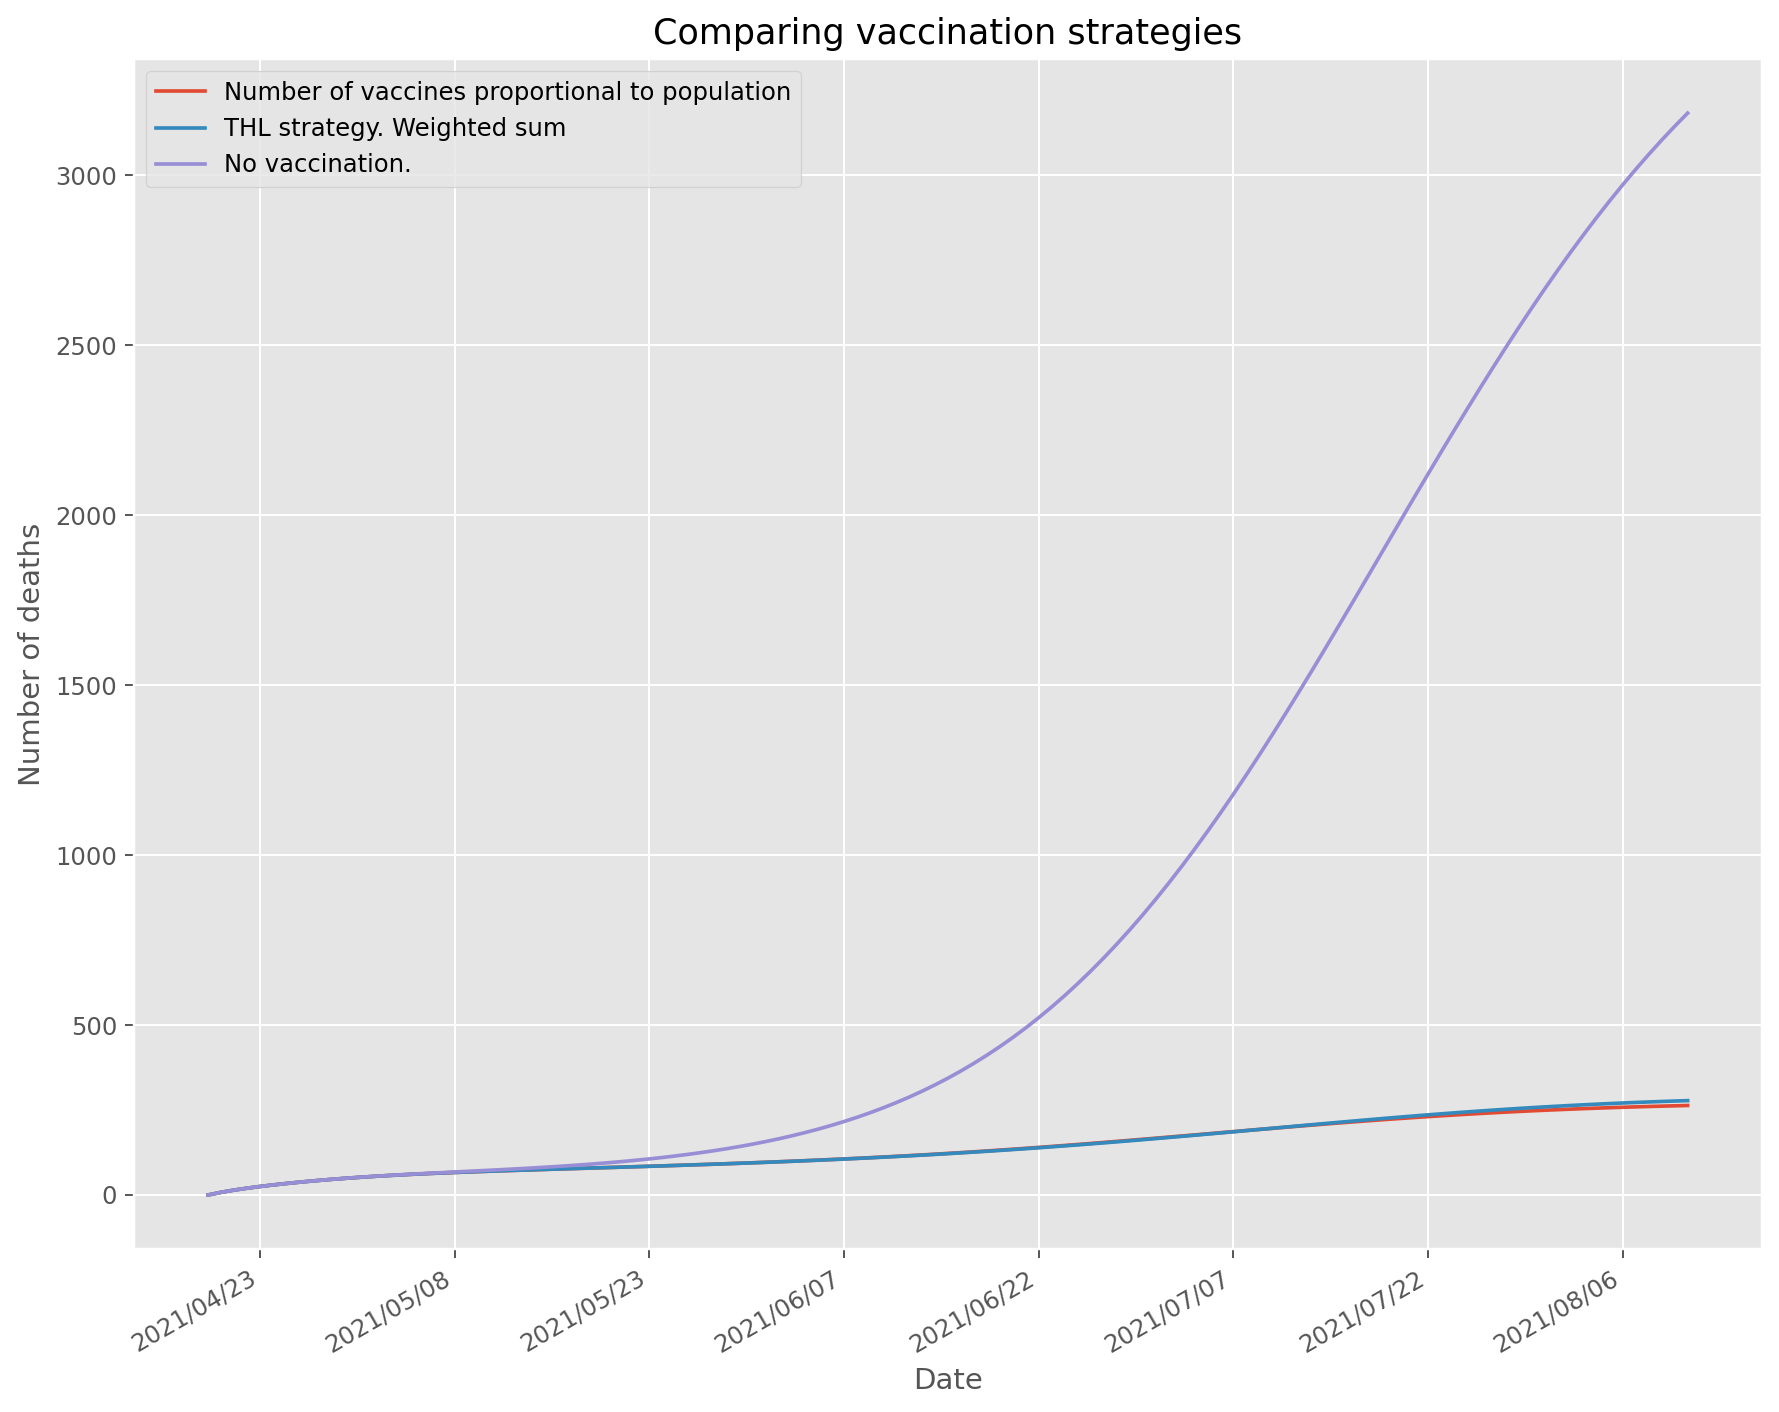

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_compare_strategies(ax=ax, D_g=D_g_plot, D_g_thl=D_g_thl_plot, D_g_no_plot=D_g_no_plot, t0=t0, T=T)

fig.autofmt_xdate()

In [20]:
total_thl = np.sum(D_g_thl_plot[:, :, -1])
total_equal = np.sum(D_g_plot[:, :, -1])
total_no = np.sum(D_g_no_plot[:, :, -1])
print('Final total deaths per strategy\n'
      'Relative to population: %f\n'
      'THL strategy: %f\n'
      'No vaccination: %f\n' % (total_equal, total_thl, total_no))

Final total deaths per strategy
Relative to population: 263.202447
THL strategy: 277.543314
No vaccination: 3183.193037

